# Performance assessment with SHORT WAVE fluxes in ARPEGE-Climat PPE

<a id="top">This code</a> is assessing model performance based on TOA Short Wave fluxes (SW) within the ARPEGE_Climat Perturbed Physics Ensemble. The metric is then used together with emulators (Multi Linear Regression) to constrain the feedback distribution in the ensemble, but also to study a subset of optimal parameter chosen with the total metric $E_{tot}$ and simulated with ARPEGE-Climat 6.3. <br> 

## It is a 6 steps method : 
### [Step 1 - EOF analysis](#EOF)
### [Step 2 - MultiLinReg predictions](#emulator)
### [Step 3 - Projection of observation dataset](#observation)
### [Step 4 - RMSE estimate](#RMSE)
### [Figure histograms](#histograms)
### [Step 5 - Optimisation](#optim)
### [Step 6 - Optimal subset of parameters](#selection)

# Importe modules

In [1]:
# Computational modules 
%matplotlib inline
import xarray as xr
import glob
import os
import numpy as np
import netCDF4
from netCDF4 import Dataset
import pandas as pd
import re
from array import array
from pylab import *
#import geopandas
from eofs.xarray import Eof
from eofs.multivariate.standard import MultivariateEof

# Plotting modules 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas.plotting
import matplotlib.ticker as ticker
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import BoundaryNorm

# Scikit-learn
from sklearn import linear_model
from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn import preprocessing
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.neural_network import MLPRegressor
from scipy.optimize import minimize
from scipy.optimize import dual_annealing

# Settings

### Variables

In [2]:
variables = ['rsut', 'rsdt']
variable = 'SW'
TITLE = 'Short Wave fluxes'
ylabel = '$E_{SW}$ ($W.m^{-2}.K^{-1}$)'

### Paths

In [3]:
path_official='/data/scratch/globc/peatier/CMIP6/CNRM-CM6-1/CFMIP/amip/'
path_PPE='/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'

### List of members

In [4]:
nb_p_list = ['p311', 'p312', 'p314', 'p316',
                    'p317', 'p319', 'p320', 'p321', 'p322', 'p324', 'p325', 'p326', 
                    'p329', 'p330', 'p331', 'p332', 'p335', 'p336', 'p337' ,'p338', 
                    'p340', 'p341', 'p343', 'p344', 'p346', 'p347', 'p348', 'p349', 
                    'p350', 'p353', 'p355', 'p357', 'p359', 'p360', 
                    'p361', 'p363', 'p365', 'p367', 'p368', 'p369', 
                    'p372', 'p373', 'p374', 'p375', 'p376', 'p378', 'p381', 'p382', 
                    'p384', 'p386', 'p388', 'p389', 'p391', 'p392', 'p393', 
                    'p394', 'p395', 'p396', 'p398', 'p399', 'p400', 'p404', 
                    'p406', 'p407', 'p409', 'p410', 'p411', 'p412',
                    'p414','p416',
                    'p413','p419','p424','p426','p428','p421','p423',
                    'p425','p427','p429','p430','p436','p438','p431','p433',
                    'p442','p446','p443','p445','p447',
                    'p452','p454','p456','p458','p457','p459',
                    'p460','p465','p467','p469',
                    'p470','p471']

len(nb_p_list)

102

# <a id="EOF">Step 1 - EOF analysis</a> </li>

For each variable, we consider the climatological mean of the model outputs and we calculate empirical orthogonal functions (EOFs) of the control mean states of the ensemble. In contrast to conventional EOFs, the temporal dimension is replaced by the ensemble itself. This analysis provides a compact description of the spatial and temporal variability of the ensemble variance control climate in term of orthogonal functions, or statistical "modes". The resulting EOFs are spatial patterns, while their principal components ($PCs$) are the expansion coefficients showing the amplitude of the EOF in each ensemble member.

### Functions

In [5]:
def get_3D_SW_xarr(path, filename, variables):

    # First step : download the data into dataframe
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    
    # Second step : compute the annual average 
    df = file[variables].mean('time', keep_attrs=True)
    SW = df['rsdt'] - df['rsut']
    
    return SW

In [6]:
def eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure):
    # Plot the EOF map 

    lat = data['lat'][:]
    lon = data['lon'][:]

    fig = plt.figure(figsize=(10, 10))
    ax=plt.gca()

    eof = eof_nb-1
    data = data[eof]
    ax.set_title(title, fontsize=18, fontweight = 'bold')

    m = Basemap(projection='robin',
            lat_0=0.5*lat[-1], lon_0=-180.0, resolution='c')
    x, y = m(*np.meshgrid(lon,lat))


    cmap = plt.get_cmap('coolwarm',16)  # define the colormap, take the number of discrete colors you want

    m.pcolormesh(x,y,data,shading='gouraud',cmap=cmap)
    #m.colorbar()
    cbar = m.colorbar(location='bottom', spacing = 'uniform', drawedges=True)
    cbar.set_label(' ', size = 16, style = 'italic')

    m.drawcoastlines()
    m.drawmapboundary()
    plt.clim(label_min, label_max)

    # Enregistrer la figure .....................

    plt.savefig("/data/home/globc/peatier/figures/"+name_figure, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

    # Show la figure .................
    plt.show()

In [7]:
def pc_plot(data, pc_nb, ymin, ymax, title, name_figure):
    #pc = solver.pcs(pcscaling=1)
    #pc = pc*-1

    # Plot the leading PC time series.
    plt.figure(figsize=(10, 5))
    
    pc = pc_nb - 1
    data[:, pc].plot(color='black', linewidth=2)
    ax = plt.gca()
    ax.axhline(0, color='k', alpha=0.5)
    #ax.axvline(x=(8+1), color='red', alpha=0.5)
    #ax.axvline(x=(11+1), color='red', alpha=0.5)
    #ax.axvline(x=(23+1), color='red', alpha=0.5)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel('Members', size = 16)
    ax.set_ylabel('Normalized Units', size = 16)
    ax.set_title(title, fontsize=18, 
             fontweight = 'bold')

    # Enregistrer la figure .....................

    plt.savefig("/data/home/globc/peatier/figures/"+name_figure, 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

    # Show la figure .................
    plt.show()

### Get the data

In [8]:
# Official
path = path_official
filename = '*_CNRM-CM6-1_amip_*.nc'
official_amip = get_3D_SW_xarr(path, filename, variables)

# Default simulation
path = path_PPE+'ENSEMBLE1/CNRM-CM6-1_amip_PPE/CNRM-CM6-1_amip_r1i1p1f2/'
filename = '*_CNRM-CM6-1_amip_*.nc'
p1_amip = get_3D_SW_xarr(path, filename, variables)

In [9]:
# PPE amip simulations 
filename='*_amip_*.nc'

N=len(nb_p_list)
amip={}
i = 0
while i<N:
    nb_p = nb_p_list[i]
    #print(nb_p)
    path=path_PPE+'ENSEMBLE2/CNRM-CM6-1_amip_LHS500_PPE/CNRM-CM6-1_amip_r1i1'+str(nb_p)+'f2/'
    amip[str(nb_p)] = get_3D_SW_xarr(path, filename, variables)
    i=i+1  

In [10]:
#amip['official'] = official_amip
amip['p1'] = p1_amip

### Create EOF input matrix

In [11]:
n=len(nb_p_list)
amip_list=[0]*(n+1)

#amip_list[0] = amip['official']
amip_list[0] = amip['p1']

i = 0
while i<n:
    nb_p = nb_p_list[i]
    #print(nb_p)
    tmp = amip[str(nb_p)]
    #j=i+1
    amip_list[i+1] = tmp
    i+=1

In [12]:
matrix = xr.combine_nested(amip_list, concat_dim=['time'])
matrix

<xarray.DataArray (time: 103, lat: 128, lon: 256)>
dask.array<concatenate, shape=(103, 128, 256), dtype=float32, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
Dimensions without coordinates: time

### EOF analysis

In [13]:
# Mean wheigted with cos(lat) : 
lats = matrix['lat'][:]
coslat = np.cos(np.deg2rad(lats)).clip(0., 1.)
wgts = np.sqrt(coslat).drop(labels='height').values
W =wgts[np.newaxis,:,np.newaxis]
#W

In [14]:
# Compute anomalies by removing the time-mean.
mean = matrix.mean(axis=0)
anom = matrix - mean
anom

<xarray.DataArray (time: 103, lat: 128, lon: 256)>
dask.array<sub, shape=(103, 128, 256), dtype=float32, chunksize=(1, 128, 256), chunktype=numpy.ndarray>
Coordinates:
    height   float64 2.0
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
Dimensions without coordinates: time

In [15]:
mean_df = mean.to_dataframe(name=str(variable)+'mean').drop(labels = 'height', axis=1)
mean_df

anom_df =  anom.to_dataframe(name=str(variables[0])+'mean').drop(labels = 'height', axis=1)
anom_df

rsutmean
time lat        lon                
0    -88.927735 0.00000   -0.788578
                1.40625   -0.788578
                2.81250   -0.788578
                4.21875   -0.788578
                5.62500   -0.788578
...                             ...
102   88.927735 352.96875  0.186493
                354.37500  0.186493
                355.78125  0.186493
                357.18750  0.186493
                358.59375  0.186493

[3375104 rows x 1 columns]

In [16]:
# Create an EOF solver to do the EOF analysis. 
solver = Eof(anom, weights=W)

eof = solver.eofsAsCovariance(neofs=10, pcscaling=1)
pc = solver.pcs(pcscaling=1)

In [17]:
varFrac = solver.varianceFraction(neigs=10)
varFrac

<xarray.DataArray 'variance_fractions' (mode: 10)>
array([0.6604892 , 0.11361258, 0.0803175 , 0.02675975, 0.01882437,
       0.01118314, 0.00921894, 0.00759234, 0.00628124, 0.0052729 ],
      dtype=float32)
Coordinates:
  * mode     (mode) int64 0 1 2 3 4 5 6 7 8 9
Attributes:
    long_name:  variance_fractions

In [18]:
pc = solver.pcs(pcscaling=1)

### EOF 1 : plotting 

In [19]:
varFrac_list = []
for i in varFrac.values :
    tmp = round(i, 2)
    varFrac_list.append(tmp)
varFrac_list

[0.66, 0.11, 0.08, 0.03, 0.02, 0.01, 0.01, 0.01, 0.01, 0.01]

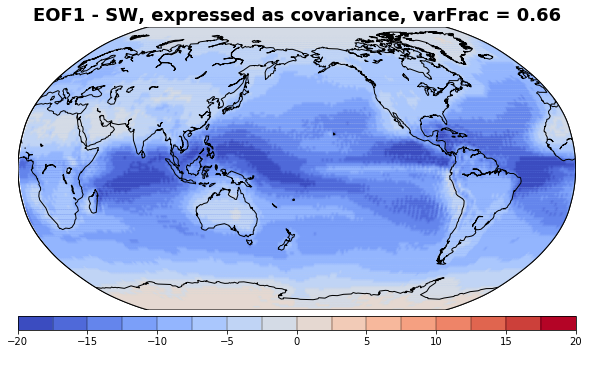

In [20]:
data = eof*(-1)
eof_nb = 1
title = "EOF1 - "+variable+", expressed as covariance, varFrac = "+str(varFrac_list[0])
label_min = -20
label_max = 20
name_figure = "PPE2_EOF1map_"+str(variable)+".png"
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

In [21]:
EOF1_df = eof[0].to_dataframe().drop(labels = 'mode', axis=1)

# Save the numpy array in a file  
EOF1_df.to_pickle("/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap1_"+str(variable)+".npy")

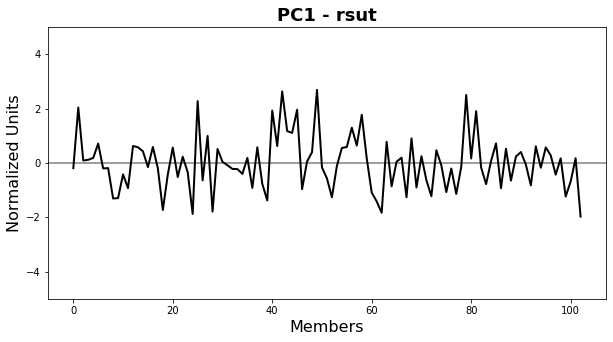

In [22]:
data = pc*(-1)
pc_nb = 1
ymin = -5
ymax = 5
title = "PC1 - "+str(variables[0])
name_figure = "PPE2_EOF1pc_"+str(variable)+".png"
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 2 : plotting 

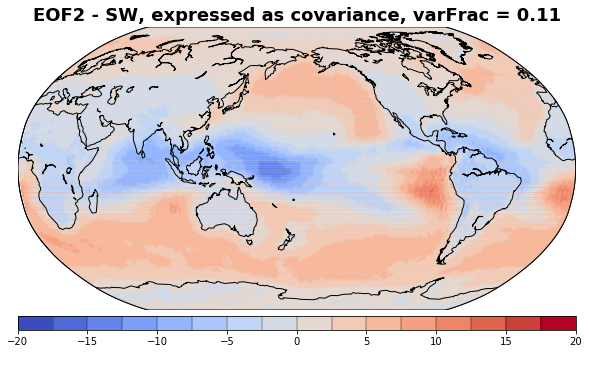

In [23]:
data = eof*(-1)
eof_nb = 2
title = "EOF2 - "+str(variable)+", expressed as covariance, varFrac = "+str(varFrac_list[1])
label_min = -20
label_max = 20
name_figure = 'PPE2_EOF2map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

In [24]:
EOF2_df = eof[1].to_dataframe().drop(labels = 'mode', axis=1)

# Save the numpy array in a file  
EOF2_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap2_'+str(variable)+'.npy')

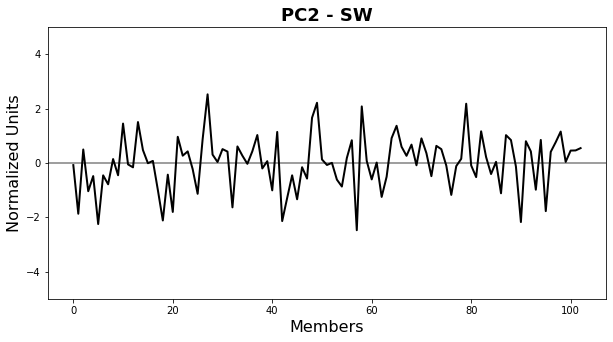

In [25]:
data = pc*(-1)
pc_nb = 2
ymin = -5
ymax = 5
title = 'PC2 - '+str(variable)
name_figure = 'PPE2_EOF2pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 3 : plotting

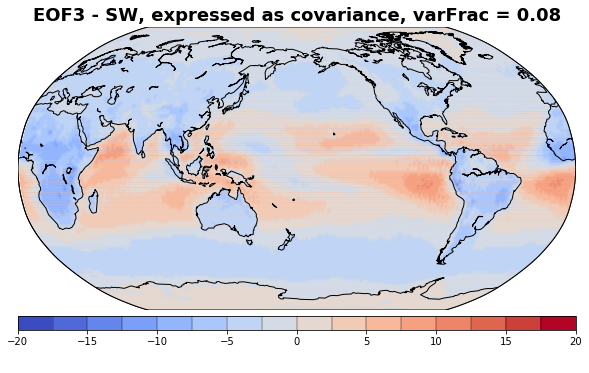

In [26]:
data = eof*(-1)
eof_nb = 3
title = 'EOF3 - '+str(variable)+', expressed as covariance, varFrac = '+str(varFrac_list[2])
label_min = -20
label_max = 20
name_figure = 'PPE2_EOF3map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

In [27]:
EOF3_df = eof[2].to_dataframe().drop(labels = 'mode', axis=1)

# Save the numpy array in a file  
EOF3_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap3_'+str(variable)+'.npy')

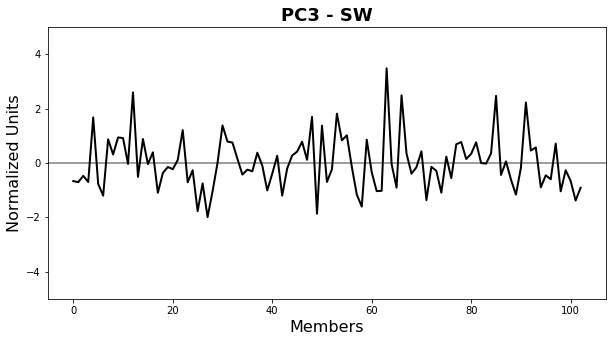

In [28]:
data = pc*(-1)
pc_nb = 3
ymin = -5
ymax = 5
title = 'PC3 - '+str(variable)
name_figure = 'PPE2_EOF3pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 4 : plotting 

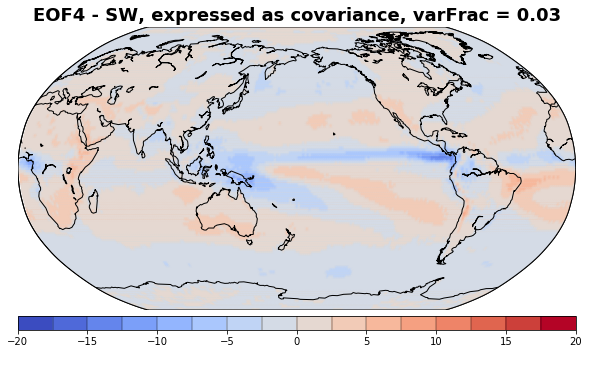

In [29]:
data = eof
eof_nb = 4
title = 'EOF4 - '+str(variable)+', expressed as covariance, varFrac = '+str(varFrac_list[3])
label_min = -20
label_max = 20
name_figure = 'PPE2_EOF4map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

In [30]:
EOF4_df = eof[3].to_dataframe().drop(labels = 'mode', axis=1)

# Save the numpy array in a file  
EOF4_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap4_'+str(variable)+'.npy')

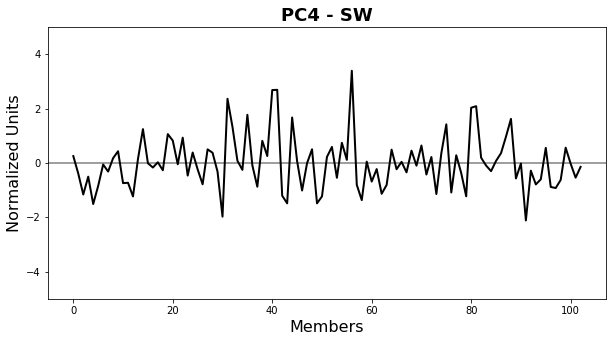

In [31]:
data = pc
pc_nb = 4
ymin = -5
ymax = 5
title = 'PC4 - '+str(variable)
name_figure = 'PPE2_EOF4pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### EOF 5 : plotting 

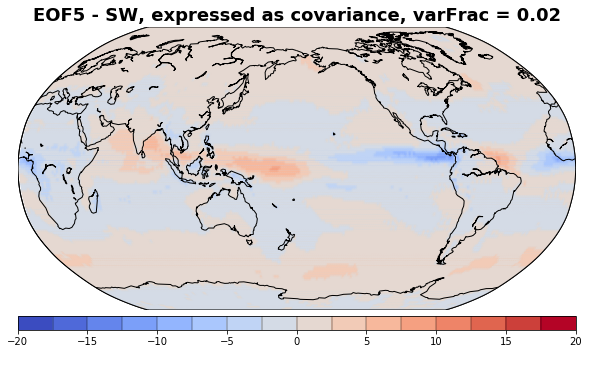

In [32]:
data = eof
eof_nb = 5
title = 'EOF5 - '+str(variable)+', expressed as covariance, varFrac = '+str(varFrac_list[4])
label_min = -20
label_max = 20
name_figure = 'PPE2_EOF5map_'+str(variable)+'.png'
eof_map_plot(data, eof_nb, title, label_min, label_max, name_figure)

In [33]:
EOF5_df = eof[4].to_dataframe().drop(labels = 'mode', axis=1)

# Save the numpy array in a file  
EOF5_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap5_'+str(variable)+'.npy')

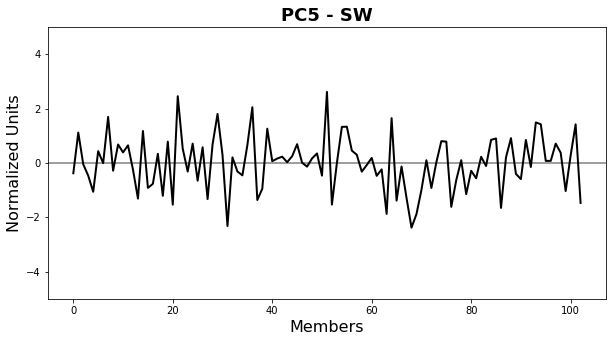

In [34]:
data = pc
pc_nb = 5
ymin = -5
ymax = 5
title = 'PC5 - '+str(variable)
name_figure = 'PPE2_EOF5pc_'+str(variable)+'.png'
pc_plot(data, pc_nb, ymin, ymax, title, name_figure)

### Save data

In [35]:
#pc1_official = pc[0, 0]
pc1_p1 = pc[0, 0]

pc1 = pc[1:, 0]

# Save the numpy array in a file   
#np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF1pc_'+str(variable)+'.npy', pc1_official)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF1pc_'+str(variable)+'.npy', pc1_p1)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_'+str(variable)+'.npy', pc1)

In [36]:
#pc2_official = pc[0,1]
pc2_p1 = pc[0,1]
pc2 = pc[1:, 1]

# Save the numpy array in a file   
#np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF2pc_'+str(variable)+'.npy', pc2_official)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF2pc_'+str(variable)+'.npy', pc2_p1)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_'+str(variable)+'.npy', pc2)

In [37]:
#pc3_official = pc[0,2]
pc3_p1 = pc[0,2]
pc3 = pc[1:, 2]

# Save the numpy array in a file   
#np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF3pc_'+str(variable)+'.npy', pc3_official)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF3pc_'+str(variable)+'.npy', pc3_p1)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_'+str(variable)+'.npy', pc3)

In [38]:
#pc4_official = pc[0, 3]
pc4_p1 = pc[0, 3]
pc4 = pc[1:, 3]

# Save the numpy array in a file   
#np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF4pc_'+str(variable)+'.npy', pc4_official)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF4pc_'+str(variable)+'.npy', pc4_p1)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_'+str(variable)+'.npy', pc4)

In [39]:
#pc5_official = pc[0, 4]
pc5_p1 = pc[0, 4]
pc5 = pc[1:, 4]

# Save the numpy array in a file   
#np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/official_EOF5pc_'+str(variable)+'.npy', pc5_official)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF5pc_'+str(variable)+'.npy', pc5_p1)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_'+str(variable)+'.npy', pc5)

In [40]:
## varFrac

# Save the numpy array in a file   
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_varFrac_'+str(variable)+'.npy', varFrac)

In [41]:
# Save the Mean and Anom numpy arrays in a file  

mean_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_'+str(variable)+'_mean.npy')
anom_df.to_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_'+str(variable)+'_anom.npy')

### [Back to the top](#top)

# <a id="emulator">Step 2 - MultiLinReg predictions</a> </li>

Use of statistical emulators to predict, based on the perturbed parameter values, ARPEGE-Climat's outputs. The emulators must predict both the climate control mean state (here the global mean tas) and the global net feedback (in another code).  


The emulator is a simple multi linear regression model built and trained to predict the five first $PCs$ of the EOF analysis estimated in [Step 1](#EOF). It is expressed as followed : 
\begin{equation}
    Y = \Sigma_{j=1}^K a_jx_j + R 
    \label{eq_emulator}
\end{equation}

with $Y = PC_i$ the PC of one mode of the EOF analysis ($i=5$), $x_j$ the parameter values, $a_j$ the regression coefficients estimated based on the training of the model, $R$ the intercept and $K=30$ the number of perturbed parameter.

### Functions

In [42]:
import sys
sys.path.append('/data/home/globc/peatier/CNRMppe')
import Fonctions_emulation
from Fonctions_emulation import Lasso_tunage
from Fonctions_emulation import Lasso_model
from Fonctions_emulation import plot_model_skill
from Fonctions_emulation import plot_model_skill_lines
from Fonctions_emulation import Lasso_pred
from Fonctions_emulation import MultiLinReg_model
from Fonctions_emulation import MultiLinReg_pred

### EOF 1 - prediction

In [43]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [44]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 -0.0018919005113485242
Coefficients: 
 [-0.35169345 -0.35265024  0.0484606  -0.05791899 -0.00403658  0.17277622
 -0.04505172  0.06793582 -0.19910663  0.21973688 -0.12526622 -0.11881877
  0.12856131  0.00450022  0.29152324  0.08315255  0.06278031 -0.0930553
 -0.02202211  0.00974109  0.01231099  0.0608608   0.02721984 -0.45608586
 -0.01920937  0.00360779  0.03950226 -0.10658601 -0.31973327 -0.02043841]
Score: 
 0.7673830751810471


,y_true,y_eq,members,members_0
0,-2.036090,-0.371384,p311,0
1,-0.087155,-0.117106,p312,1
2,-0.114481,-0.228679,p314,2
3,-0.182461,-0.072467,p316,3
4,-0.710522,0.668184,p317,4
...,...,...,...,...
97,-0.168720,0.297934,p465,97
98,1.238500,1.251831,p467,98
99,0.689616,0.575841,p469,99
100,-0.171863,0.522007,p470,100


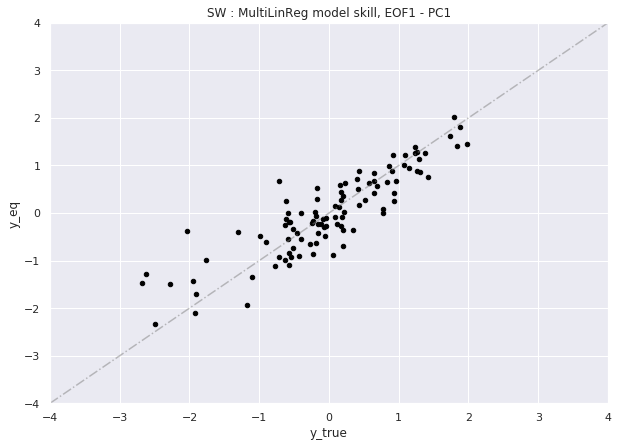

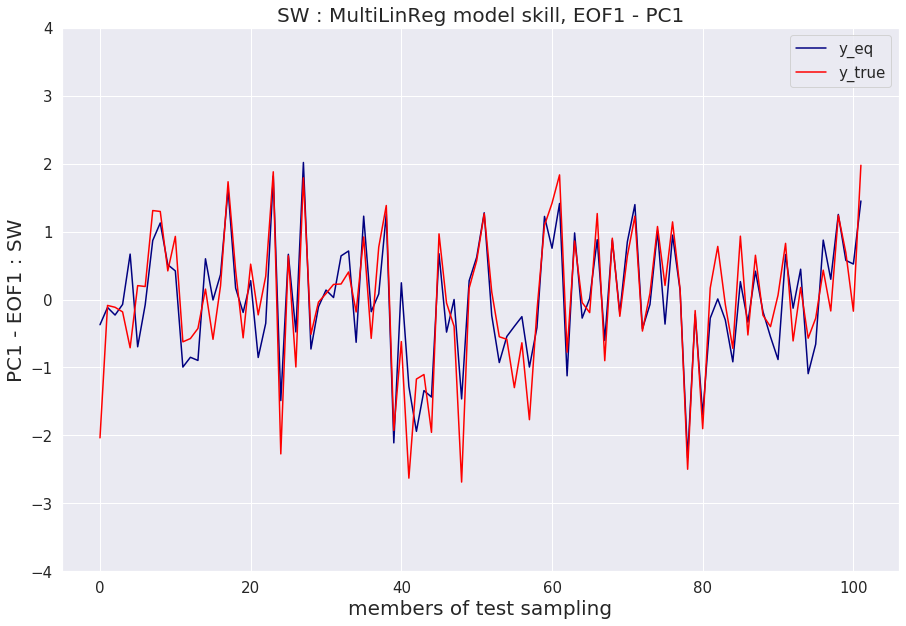

In [45]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF1 - PC1'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc1.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC1 - EOF1 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [46]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,0.469545,102.0
1,0.288395,103.0
2,-0.596403,104.0
3,0.173458,105.0
4,0.480972,106.0
...,...,...
99995,0.484390,100097.0
99996,-0.497007,100098.0
99997,-0.589315,100099.0
99998,-0.702393,100100.0


#### Save data

In [47]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof1_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof1_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 2 - prediction

In [48]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [49]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 -0.0007996995609219693
Coefficients: 
 [ 0.13507289  0.1616406  -0.06471013 -0.05182293  0.1604348  -0.37039876
 -0.1026201   0.12598392  0.02372044  0.20882572  0.03703453  0.19763448
 -0.47481278 -0.06997863  0.22978754  0.07763014 -0.06114966  0.10820225
 -0.07829268  0.09793743 -0.02654759 -0.11484413  0.0544886  -0.12575655
  0.034513   -0.05450029  0.04019709 -0.03334163 -0.0372723   0.12275656]
Score: 
 0.8185511571510675


,y_true,y_eq,members,members_0
0,1.870624,1.024411,p311,0
1,-0.493208,-0.485534,p312,1
2,1.041783,1.170367,p314,2
3,0.484756,0.788453,p316,3
4,2.249795,1.510361,p317,4
...,...,...,...,...
97,-1.152742,-0.502396,p465,97
98,-0.037123,-0.167176,p467,98
99,-0.453503,-0.778914,p469,99
100,-0.458835,-0.379446,p470,100


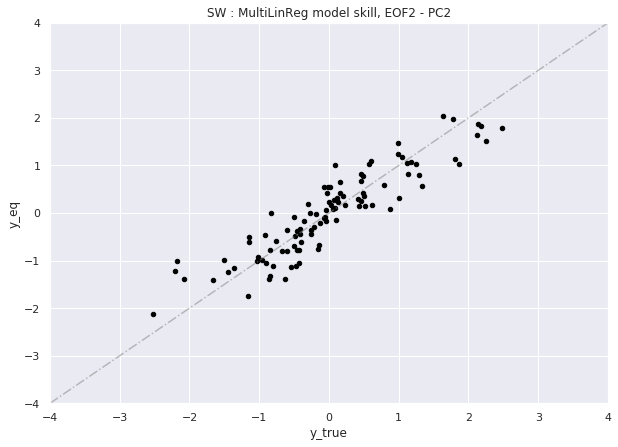

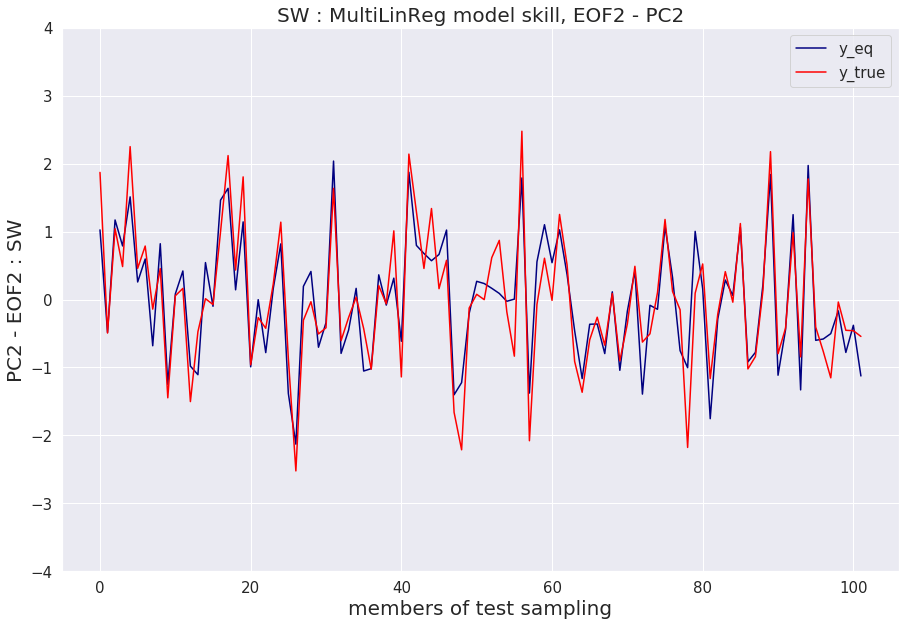

In [50]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF2 - PC2'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc2.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC2 - EOF2 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [51]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,0.877525,102.0
1,-0.716343,103.0
2,1.055428,104.0
3,-0.155816,105.0
4,0.276574,106.0
...,...,...
99995,-1.665530,100097.0
99996,-0.968395,100098.0
99997,1.286982,100099.0
99998,1.294930,100100.0


#### Save data

In [52]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof2_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof2_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 3 - prediction

In [53]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [54]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 -0.0065638580971268175
Coefficients: 
 [-0.15475935 -0.2791272  -0.49387945  0.00890225  0.06717661 -0.5317552
  0.02820959  0.03699261 -0.12730347  0.11802063  0.08377098 -0.27801385
  0.2107168   0.02681758 -0.19207863 -0.05851361 -0.08369845 -0.14445602
 -0.07801927 -0.06648022 -0.00065536  0.07088412 -0.00233843  0.02373286
 -0.08091457 -0.00540912 -0.04661922  0.01647261 -0.25000471 -0.13814771]
Score: 
 0.8000364477853587


,y_true,y_eq,members,members_0
0,0.707114,-0.410438,p311,0
1,0.475993,0.157410,p312,1
2,0.702235,0.809975,p314,2
3,-1.673981,-1.087064,p316,3
4,0.770515,0.573692,p317,4
...,...,...,...,...
97,1.045304,0.850715,p465,97
98,0.270798,0.085574,p467,98
99,0.660136,0.724185,p469,99
100,1.383297,1.962446,p470,100


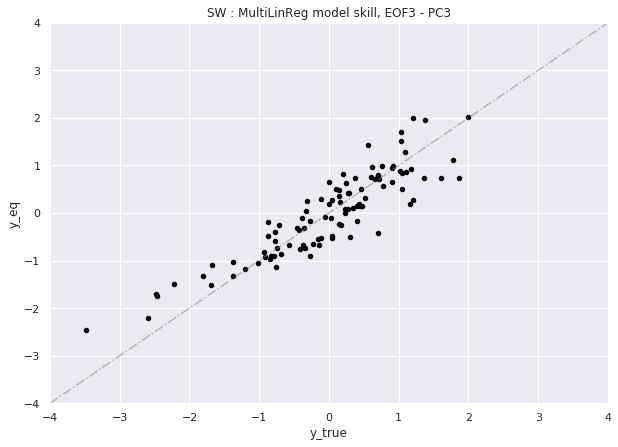

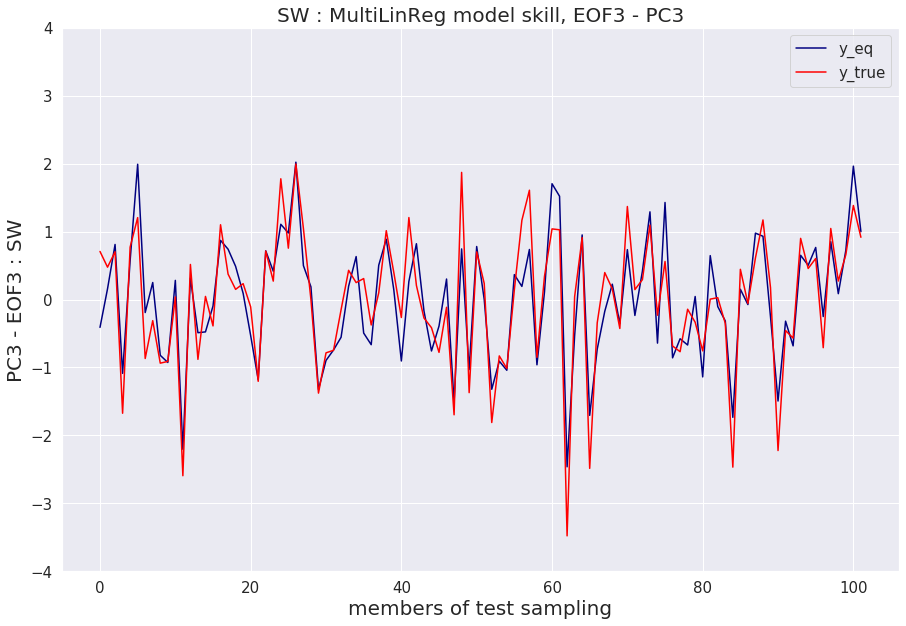

In [55]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF3 - PC3'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc3.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC3 - EOF3 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [56]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,0.191922,102.0
1,0.065012,103.0
2,0.368145,104.0
3,0.840631,105.0
4,-1.317609,106.0
...,...,...
99995,-0.497648,100097.0
99996,0.502236,100098.0
99997,0.474995,100099.0
99998,1.998083,100100.0


#### Save data

In [57]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof3_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof3_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 4 - prediction

In [58]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [59]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 -0.0024535066320325043
Coefficients: 
 [-0.11203362 -0.40753013 -0.19100122  0.06576412 -0.0384753  -0.27121142
 -0.00781825 -0.17825023  0.02615957 -0.60181944  0.10960326  0.21080462
 -0.20823314 -0.11978122  0.19380078  0.06958851  0.01925008 -0.03662701
  0.18968207 -0.04730431  0.062217    0.07299121 -0.26913463 -0.01224114
  0.03481156  0.08483329 -0.08021994  0.05460806  0.11477442 -0.02609694]
Score: 
 0.7926846978271489


,y_true,y_eq,members,members_0
0,-0.396013,0.215728,p311,0
1,-1.162121,-0.772116,p312,1
2,-0.506069,-0.894919,p314,2
3,-1.513304,-0.976040,p316,3
4,-0.845883,-0.407241,p317,4
...,...,...,...,...
97,-0.624217,-0.662007,p465,97
98,0.559803,-0.176310,p467,98
99,-0.027370,0.283869,p469,99
100,-0.542851,-0.481290,p470,100


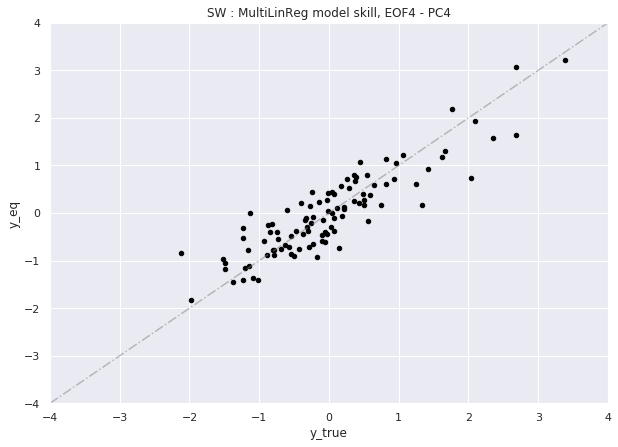

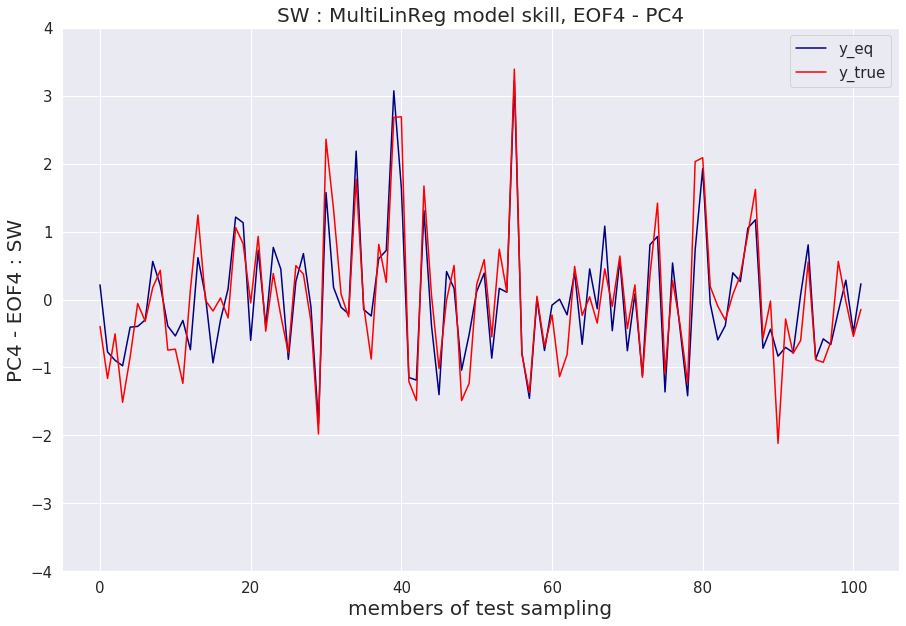

In [60]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF4 - PC4'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc4.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC4 - EOF4 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [61]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,0.966753,102.0
1,1.781040,103.0
2,-0.793781,104.0
3,0.168080,105.0
4,0.043341,106.0
...,...,...
99995,0.831704,100097.0
99996,0.440812,100098.0
99997,0.072422,100099.0
99998,0.778176,100100.0


#### Save data

In [62]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof4_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof4_'+variable+'.npy', 
        MultiLinReg_prediction)

### EOF 5 - prediction

In [63]:
# Set the X and Y : Y = f(X)
X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_"+variable+".npy")
param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

In [64]:
DFYeq = MultiLinReg_model(X,y,param_names, nb_p_list)
DFYeq

Intercept: 
 0.003734555501746914
Coefficients: 
 [ 0.00961261  0.00926344  0.0289868  -0.14340818  0.0666114   0.08525577
 -0.04414627 -0.00495836 -0.19206864  0.00831943  0.07132763 -0.25423885
  0.09705915 -0.12207098  0.33958862 -0.05226433 -0.13625322  0.14247017
 -0.05704316  0.19582393 -0.1715956  -0.14186496 -0.03549817  0.42864561
  0.0271943  -0.00922227  0.01483547 -0.1371094  -0.40175322  0.02370102]
Score: 
 0.8628469435273459


,y_true,y_eq,members,members_0
0,1.116171,-0.014231,p311,0
1,-0.052267,0.040817,p312,1
2,-0.471244,-0.352534,p314,2
3,-1.062389,-1.455397,p316,3
4,0.433661,0.009936,p317,4
...,...,...,...,...
97,0.373184,1.282008,p465,97
98,-1.034781,-1.029888,p467,98
99,0.274178,0.258731,p469,99
100,1.417712,1.064809,p470,100


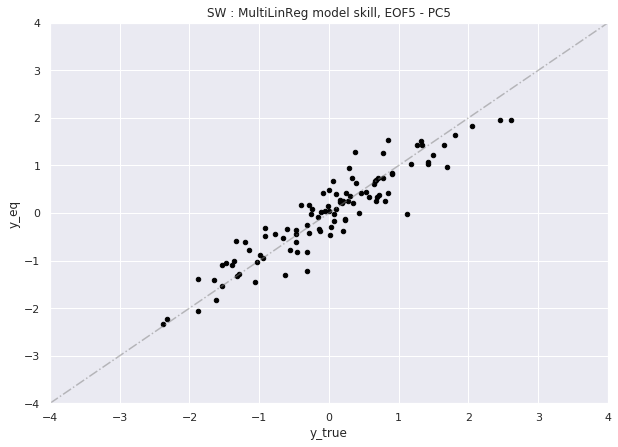

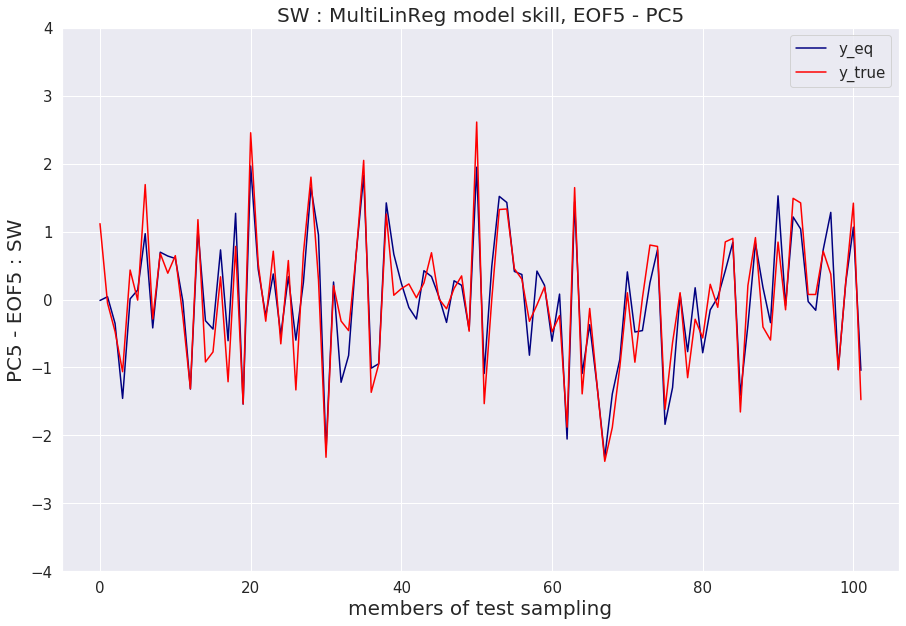

In [65]:
df = DFYeq
title = variable+' : MultiLinReg model skill, EOF5 - PC5'
xmin = -4
xmax = 4
ymin = -4
ymax = 4
name = 'MultiLinReg_'+variable+'_skill_pc5.png'

plot_model_skill(df, title, xmin, xmax, ymin, ymax, name)

xlabel = 'members of test sampling'
ylabel = 'PC5 - EOF5 : '+variable

plot_model_skill_lines(df, title, xlabel, ylabel, ymin, ymax)

In [66]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param_standard.npy")

DFYpred = MultiLinReg_pred(LHS,X,y, param_names)
DFYpred

,y_pred,members
0,-0.063704,102.0
1,1.450278,103.0
2,-1.606194,104.0
3,1.034677,105.0
4,0.399288,106.0
...,...,...
99995,-1.084613,100097.0
99996,-0.082301,100098.0
99997,-0.269948,100099.0
99998,1.313871,100100.0


#### Save data

In [67]:
MultiLinReg_validation = DFYeq['y_eq'].values
MultiLinReg_prediction = DFYpred['y_pred'].values

# Save the predictionc in numpy arrays : 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof5_'+variable+'.npy', 
        MultiLinReg_validation)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof5_'+variable+'.npy', 
        MultiLinReg_prediction)

### [Back to the top](#top)

# <a id="observation">Step 3 - Projection of observation dataset</a> </li>

In this section, we project the observations ($X_{obs}$) onto the EOFs calculated in [Step 1](#EOF). We call $U_{ens}$ the ensemble matrix of EOF amplitudes $w$ such as :  

$U_{ens} = \begin{pmatrix} 
                w_{1,1} & w_{2,1} & w_{3,1} & w_{4,1} & w_{5,1} \\ 
                ... & ... & ... & ... & ... \\
                w_{1,102} & w_{2,102} & w_{3,102} & w_{4,102} & w_{5,102}
           \end{pmatrix}$ 
           
           
<br>
<br>
<br>
The ensemble matrix of spatial patterns is called $v_{ens}$ and is expresses such as : 

$v_{ens} = \begin{pmatrix} 
                eof1(lat,lon)  \\ 
                eof2(lat,lon)  \\ 
                eof3(lat,lon)  \\ 
                eof4(lat,lon)  \\ 
                eof5(lat,lon)  \\ 
           \end{pmatrix}$ 


<br>

The EOF analysis can be expresses as : 
$X_{ens} = U_{ens} \cdot v_{ens}$

And we want the EOF amplitudes of the observations within this basis such as : 

$X_{obs} = U_{obs} \cdot v_{ens}$ 

$U_{obs} = X_{obs} \cdot {v_{ens}}^{-1}$

With : 

$U_{obs} = \begin{pmatrix} 
                o_{1,1} & o_{2,1} & o_{3,1} & o_{4,1} & o_{5,1} \\ 
                ... & ... & ... & ... & ... \\
                o_{1,102} & o_{2,102} & o_{3,102} & o_{4,102} & o_{5,102}
           \end{pmatrix}$ 

### Settings

In [68]:
path_observation = '/data/home/globc/peatier/obs_data/CERES/'
filename = 'CERES_EBAF-TOA_Ed4.1_Subset_200003-201910_regrid.nc'

### Functions

In [69]:
def load_monthly_clim(path, filename, variables) :
    
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df=file[variables].to_dataframe()
    
    # Compute Climatological Annual Cycle :
    df1=df.reset_index(level=['time', 'lat', 'lon'])
    df1['year']=pd.DatetimeIndex(df1['time']).year
    df1['month']=pd.DatetimeIndex(df1['time']).month
    
    #list_ind = []
    #cpt=0
    #for i in df1['year'] : 
    #    if i>1981 :
    #        list_ind.append(cpt)
    #        cpt+=1
    #    else : 
    #        cpt+=1
            
    #df2 = df1.drop(list_ind)
    df_mean=df1.groupby(['month', 'lat', 'lon']).mean()
    df_mean=df_mean.drop(columns='year')
    
    return df_mean

### Get the data 

In [70]:
Mean =  pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_'+variable+'_mean.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})
Mean

<xarray.DataArray (lat: 128, lon: 256)>
array([[46.2103  , 46.2103  , 46.2103  , ..., 46.2103  , 46.2103  ,
        46.2103  ],
       [52.110836, 52.110836, 52.110836, ..., 52.110836, 52.110836,
        52.110836],
       [49.190533, 49.190533, 49.190533, ..., 49.07198 , 49.190533,
        49.190533],
       ...,
       [57.36108 , 57.36108 , 57.36108 , ..., 57.962273, 57.36108 ,
        57.36108 ],
       [56.612976, 56.612976, 56.612976, ..., 56.612976, 56.612976,
        56.612976],
       [55.84883 , 55.84883 , 55.84883 , ..., 55.84883 , 55.84883 ,
        55.84883 ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    mode     <U6 'SWmean'

In [71]:
eof1 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap1_'+variable+'.npy').to_xarray().to_array()
eof2 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap2_'+variable+'.npy').to_xarray().to_array()
eof3 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap3_'+variable+'.npy').to_xarray().to_array()
eof4 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap4_'+variable+'.npy').to_xarray().to_array()
eof5 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap5_'+variable+'.npy').to_xarray().to_array()

eof1 = eof1[0,:,:].rename({'variable':'mode'})
eof2 = eof2[0,:,:].rename({'variable':'mode'})
eof3 = eof3[0,:,:].rename({'variable':'mode'})
eof4 = eof4[0,:,:].rename({'variable':'mode'})
eof5 = eof5[0,:,:].rename({'variable':'mode'})

eofs = [eof1,eof2,eof3,eof4,eof5]

eofs_combined = xr.combine_nested(eofs, concat_dim='eofs')

In [72]:
pc1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_'+variable+'.npy')
pc2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_'+variable+'.npy')
pc3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_'+variable+'.npy')
pc4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_'+variable+'.npy')
pc5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_'+variable+'.npy')

PC_df = pd.DataFrame(pc1)
PC_df['pc1'] = pc1
PC_df['pc2'] = pc2
PC_df['pc3'] = pc3
PC_df['pc4'] = pc4
PC_df['pc5'] = pc5
PC_df = PC_df.drop(labels = 0, axis=1)

#PC_df

In [73]:
# Load data and compute Annual Cycle :
file = xr.open_mfdataset(path_observation+filename,combine='by_coords')
#file
variables = ['toa_sw_all_mon','toa_lw_all_mon', 'toa_net_all_mon']
df_obs = load_monthly_clim(path_observation, filename, variables)
df_obs

toa_sw_all_mon  toa_lw_all_mon  toa_net_all_mon
month lat        lon                                                       
1     -88.927735 0.00000        344.953522      189.246185       -38.599289
                 1.40625        344.953522      189.246185       -38.599289
                 2.81250        344.953522      189.246185       -38.599289
                 4.21875        344.992493      189.144440       -38.531315
                 5.62500        345.007721      189.104630       -38.504715
...                                    ...             ...              ...
12     88.927735 352.96875        0.000000      171.476639      -171.476639
                 354.37500        0.000000      171.476639      -171.476639
                 355.78125        0.000000      171.500351      -171.500351
                 357.18750        0.000000      171.560974      -171.560974
                 358.59375        0.000000      171.560974      -171.560974

[393216 rows x 3 columns]

In [74]:
df_obs['SW'] =  df_obs['toa_net_all_mon'] + df_obs['toa_lw_all_mon']
obs = df_obs.groupby(['lat','lon']).mean().to_xarray()
obs

<xarray.Dataset>
Dimensions:          (lat: 128, lon: 256)
Coordinates:
  * lat              (lat) float64 -88.93 -87.54 -86.14 ... 86.14 87.54 88.93
  * lon              (lon) float64 0.0 1.406 2.812 4.219 ... 355.8 357.2 358.6
Data variables:
    toa_sw_all_mon   (lat, lon) float32 121.35958 121.35958 ... 103.85324
    toa_lw_all_mon   (lat, lon) float32 142.8201 142.8201 ... 194.14125
    toa_net_all_mon  (lat, lon) float32 -91.40278 -91.40278 ... -126.49493
    SW               (lat, lon) float32 51.417324 51.417324 ... 67.64632

### Compute anomalies 

In [76]:
X_obs = obs[variable] - Mean
X_obs_bis = X_obs.expand_dims(dim={'dummy':range(0,102,1)})
X_obs_bis

<xarray.DataArray (dummy: 102, lat: 128, lon: 256)>
array([[[ 5.2070236,  5.2070236,  5.2070236, ...,  5.226471 ,
          5.2070236,  5.2070236],
        [ 1.2220192,  1.2220192,  1.2220192, ...,  1.2446327,
          1.2220192,  1.2220192],
        [ 4.9539795,  4.9539795,  4.9539795, ...,  5.0742836,
          4.9539795,  4.9539795],
        ...,
        [11.637173 , 11.637173 , 11.637173 , ..., 11.104774 ,
         11.637173 , 11.637173 ],
        [11.558968 , 11.558968 , 11.558968 , ..., 11.514648 ,
         11.558968 , 11.558968 ],
        [11.797485 , 11.797485 , 11.797485 , ..., 11.795776 ,
         11.797485 , 11.797485 ]],

       [[ 5.2070236,  5.2070236,  5.2070236, ...,  5.226471 ,
          5.2070236,  5.2070236],
        [ 1.2220192,  1.2220192,  1.2220192, ...,  1.2446327,
          1.2220192,  1.2220192],
        [ 4.9539795,  4.9539795,  4.9539795, ...,  5.0742836,
          4.9539795,  4.9539795],
        ...,
        [11.637173 , 11.637173 , 11.637173 , ..., 11.104774 ,
         11.637173 , 11.637173 ],
        [11.558968 , 11.558968 , 11.558968 , ..., 11.514648 ,
         11.558968 , 11.558968 ],
        [11.797485 , 11.797485 , 11.797485 , ..., 11.795776 ,
         11.797485 , 11.797485 ]],

       [[ 5.2070236,  5.2070236,  5.2070236, ...,  5.226471 ,
          5.2070236,  5.2070236],
        [ 1.2220192,  1.2220192,  1.2220192, ...,  1.2446327,
          1.2220192,  1.2220192],
        [ 4.9539795,  4.9539795,  4.9539795, ...,  5.0742836,
          4.9539795,  4.9539795],
        ...,
        [11.637173 , 11.637173 , 11.637173 , ..., 11.104774 ,
         11.637173 , 11.637173 ],
        [11.558968 , 11.558968 , 11.558968 , ..., 11.514648 ,
         11.558968 , 11.558968 ],
        [11.797485 , 11.797485 , 11.797485 , ..., 11.795776 ,
         11.797485 , 11.797485 ]],

       ...,

       [[ 5.2070236,  5.2070236,  5.2070236, ...,  5.226471 ,
          5.2070236,  5.2070236],
        [ 1.2220192,  1.2220192,  1.2220192, ...,  1.2446327,
          1.2220192,  1.2220192],
        [ 4.9539795,  4.9539795,  4.9539795, ...,  5.0742836,
          4.9539795,  4.9539795],
        ...,
        [11.637173 , 11.637173 , 11.637173 , ..., 11.104774 ,
         11.637173 , 11.637173 ],
        [11.558968 , 11.558968 , 11.558968 , ..., 11.514648 ,
         11.558968 , 11.558968 ],
        [11.797485 , 11.797485 , 11.797485 , ..., 11.795776 ,
         11.797485 , 11.797485 ]],

       [[ 5.2070236,  5.2070236,  5.2070236, ...,  5.226471 ,
          5.2070236,  5.2070236],
        [ 1.2220192,  1.2220192,  1.2220192, ...,  1.2446327,
          1.2220192,  1.2220192],
        [ 4.9539795,  4.9539795,  4.9539795, ...,  5.0742836,
          4.9539795,  4.9539795],
        ...,
        [11.637173 , 11.637173 , 11.637173 , ..., 11.104774 ,
         11.637173 , 11.637173 ],
        [11.558968 , 11.558968 , 11.558968 , ..., 11.514648 ,
         11.558968 , 11.558968 ],
        [11.797485 , 11.797485 , 11.797485 , ..., 11.795776 ,
         11.797485 , 11.797485 ]],

       [[ 5.2070236,  5.2070236,  5.2070236, ...,  5.226471 ,
          5.2070236,  5.2070236],
        [ 1.2220192,  1.2220192,  1.2220192, ...,  1.2446327,
          1.2220192,  1.2220192],
        [ 4.9539795,  4.9539795,  4.9539795, ...,  5.0742836,
          4.9539795,  4.9539795],
        ...,
        [11.637173 , 11.637173 , 11.637173 , ..., 11.104774 ,
         11.637173 , 11.637173 ],
        [11.558968 , 11.558968 , 11.558968 , ..., 11.514648 ,
         11.558968 , 11.558968 ],
        [11.797485 , 11.797485 , 11.797485 , ..., 11.795776 ,
         11.797485 , 11.797485 ]]], dtype=float32)
Coordinates:
  * dummy    (dummy) int64 0 1 2 3 4 5 6 7 8 9 ... 93 94 95 96 97 98 99 100 101
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    mode     <U6 'SWmean'

### Inverse the EOF matrix $v_{ens}$

In [77]:
eofs_inv = np.linalg.pinv(eofs_combined.transpose())
#eofs_inv = xr.DataArray(eofs_inv, dims=['eofs','lon','lat'])
#eofs_inv

### Compute $U_{obs}$

In [78]:
U_obs = np.dot(eofs_inv,X_obs_bis.transpose('lon','lat', 'dummy'))
#U_ens = U_ens.mean(dim=['lat','lon'])#.transpose()
#U_obs

In [79]:
U_obs = xr.DataArray(U_obs, dims=['lon','eofs','lon2', 'dummy'])
U_obs_avg = U_obs[0,:,0,0].transpose()
U_obs_avg

<xarray.DataArray (eofs: 5)>
array([ 0.4596261 ,  3.1703587 ,  0.55878085, -0.76288223,  1.4074244 ],
      dtype=float32)
Dimensions without coordinates: eofs

### Save data

In [80]:
#Save the U_obs_avg 
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy', U_obs_avg)

### [Back to the top](#top)

# <a id="RMSE">Step 4 - RMSE estimate</a> </li>

The model error as compared to observations is calculated by comparing the EOF amplitudes $w$ in each member with the projection of the observations $o$ on the model EOF basis through a Root Mean Square Error (RMSE). For a given member of the PPE, the error associated with the variable $s$ is : 

\begin{equation}
    E_{s} = \sqrt{\Sigma_i^N \frac{(w_{is}-o_{is})^2}{N}}
\end{equation}

with $i$ varying from $1$ to $N$, the number of modes considered. In the present study, we truncated the EOF after the 5th mode for each variable : $N=5$.

### Settings

In [5]:
product = 'CERES'

### Functions

In [6]:
def Error_emulator(pc1, pc2, pc3, pc4, pc5, variable):
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/5)
    return E

In [7]:
def Error(path, filename, U_obs):
    
    U = np.load(path+filename)

    pc1 = U[0]
    pc2 = U[1]
    pc3 = U[2]
    pc4 = U[3]
    pc5 = U[4]

    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/5)
    return E

In [8]:
def RMSE_emulator(pc1, pc2, pc3, pc4, pc5, variable) : 
    
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    
    E_pc1 = []
    E_pc2 = []
    E_pc3 = []
    E_pc4 = []
    E_pc5 = []
    E_tmp = []

    for i in pc1:
        tmp = (i-U_obs[0])**2
        E_pc1.append(tmp)
    
    for j in pc2:
        tmp = (j-U_obs[1])**2
        E_pc2.append(tmp)

    for k in pc3:
        tmp = (k-U_obs[2])**2
        E_pc3.append(tmp)
    
    for l in pc4:
        tmp = (l-U_obs[3])**2
        E_pc4.append(tmp)
    
    for m in pc5:
        tmp = (m-U_obs[4])**2
        E_pc5.append(tmp)

    for n in range(0,len(E_pc1),1) :    
        tmp = E_pc1[n]+E_pc2[n]+E_pc3[n]+E_pc4[n]+E_pc5[n]
        E_tmp.append(tmp/5)

    
    E = sqrt(E_tmp)
    
    
    return E

### Get the data 

In [9]:
U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')

pc1_obs = U_obs[0]
pc2_obs = U_obs[1]
pc3_obs = U_obs[2]
pc4_obs = U_obs[3]
pc5_obs = U_obs[4]

### p1 default model

In [10]:
pc1_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF1pc_'+variable+'.npy')
pc2_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF2pc_'+variable+'.npy')
pc3_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF3pc_'+variable+'.npy')
pc4_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF4pc_'+variable+'.npy')
pc5_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/p1_EOF5pc_'+variable+'.npy')

p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')

In [11]:
E_p1_tmp = (pc1_p1-pc1_obs)**2 + (pc2_p1-pc2_obs)**2 + (pc3_p1-pc3_obs)**2 + (pc4_p1-pc4_obs)**2 + (pc5_p1-pc5_obs)**2
E_p1 = sqrt(E_p1_tmp/5)
        
print(E_p1)

1.6642489996403333


### CMIP6 models

In [12]:
path = '/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/'

filename = 'U_MRI_'+variable+'.npy'
E_MRI = Error(path, filename, U_obs)

filename = 'U_CAN_'+variable+'.npy'
E_CAN = Error(path, filename, U_obs)

filename = 'U_MIROC_'+variable+'.npy'
E_MIROC = Error(path, filename, U_obs)

filename = 'U_HadGEM3_'+variable+'.npy'
E_HadGEM3 = Error(path, filename, U_obs)

filename = 'U_IPSL_'+variable+'.npy'
E_IPSL = Error(path, filename, U_obs)

filename = 'U_BCC_'+variable+'.npy'
E_BCC = Error(path, filename, U_obs)

### PPE

In [13]:
eof1 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap1_'+variable+'.npy').to_xarray().to_array()
eof2 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap2_'+variable+'.npy').to_xarray().to_array()
eof3 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap3_'+variable+'.npy').to_xarray().to_array()
eof4 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap4_'+variable+'.npy').to_xarray().to_array()
eof5 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap5_'+variable+'.npy').to_xarray().to_array()

eof1 = eof1[0,:,:].rename({'variable':'mode'})
eof2 = eof2[0,:,:].rename({'variable':'mode'})
eof3 = eof3[0,:,:].rename({'variable':'mode'})
eof4 = eof4[0,:,:].rename({'variable':'mode'})
eof5 = eof5[0,:,:].rename({'variable':'mode'})

In [14]:
pc1_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_'+variable+'.npy')
pc2_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_'+variable+'.npy')
pc3_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_'+variable+'.npy')
pc4_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_'+variable+'.npy')
pc5_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_'+variable+'.npy')

PC_df_PPE = pd.DataFrame(pc1_PPE)
PC_df_PPE['pc1'] = pc1_PPE
PC_df_PPE['pc2'] = pc2_PPE
PC_df_PPE['pc3'] = pc3_PPE
PC_df_PPE['pc4'] = pc4_PPE
PC_df_PPE['pc5'] = pc5_PPE
PC_df_PPE = PC_df_PPE.drop(labels = 0, axis=1)
PC_df_PPE

,pc1,pc2,pc3,pc4,pc5
0,-2.036090,1.870624,0.707114,-0.396013,1.116171
1,-0.087155,-0.493208,0.475993,-1.162121,-0.052267
2,-0.114481,1.041783,0.702235,-0.506069,-0.471244
3,-0.182461,0.484756,-1.673981,-1.513304,-1.062389
4,-0.710522,2.249795,0.770515,-0.845883,0.433661
...,...,...,...,...,...
97,-0.168720,-1.152742,1.045304,-0.624217,0.373184
98,1.238500,-0.037123,0.270798,0.559803,-1.034781
99,0.689616,-0.453503,0.660136,-0.027370,0.274178
100,-0.171863,-0.458835,1.383297,-0.542851,1.417712


In [15]:
E_PPE = RMSE_emulator(pc1_PPE, pc2_PPE, pc3_PPE, pc4_PPE, pc5_PPE, variable)
E_PPE

array([1.27744546, 1.78983979, 1.30202623, 1.96331754, 0.80207478,
       1.43808373, 1.27018171, 1.79975739, 1.56625998, 2.21457854,
       1.46822612, 2.15050604, 2.49513948, 2.01052159, 1.80611394,
       1.87701608, 1.17103476, 1.40413994, 1.50838881, 1.68486994,
       1.95528471, 1.95070781, 1.79001781, 1.58387099, 1.87586235,
       1.84737249, 3.02222655, 1.78357269, 1.54068128, 2.01206826,
       2.77346914, 1.41000516, 1.92334242, 1.76363841, 1.86155981,
       1.67863063, 2.33419644, 1.85169173, 1.58559327, 2.19304674,
       2.60337112, 1.58783566, 1.3230142 , 1.88522019, 1.50574316,
       1.62078244, 1.44150419, 2.54179401, 2.90654388, 1.91879363,
       1.5505089 , 2.06311707, 1.69060511, 1.44929178, 1.76502476,
       2.73671853, 0.81039281, 2.71942237, 1.77512322, 1.3052752 ,
       1.73859416, 1.31401768, 2.67251397, 1.93423762, 2.41046792,
       2.31843419, 2.03329812, 2.54836055, 2.05586245, 2.27088518,
       1.73009011, 1.69340596, 1.86585011, 1.76356076, 1.76443

### Multi-Linear Regression predictions

In [16]:
pc1_pred = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof1_'+variable+'.npy')
pc2_pred = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof2_'+variable+'.npy')
pc3_pred = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof3_'+variable+'.npy')
pc4_pred = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof4_'+variable+'.npy')
pc5_pred = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_eof5_'+variable+'.npy')

PC_df = pd.DataFrame(pc1_pred)
PC_df['pc1'] = pc1_pred
PC_df['pc2'] = pc2_pred
PC_df['pc3'] = pc3_pred
PC_df['pc4'] = pc4_pred
PC_df['pc5'] = pc5_pred
PC_df = PC_df.drop(labels = 0, axis=1)
#PC_df

pc1_pred = PC_df['pc1'].to_xarray().rename({'index':'mode'})
pc2_pred = PC_df['pc2'].to_xarray().rename({'index':'mode'})
pc3_pred = PC_df['pc3'].to_xarray().rename({'index':'mode'})
pc4_pred = PC_df['pc4'].to_xarray().rename({'index':'mode'})
pc5_pred = PC_df['pc5'].to_xarray().rename({'index':'mode'})

In [17]:
pc1_val = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof1_'+variable+'.npy')
pc2_val = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof2_'+variable+'.npy')
pc3_val = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof3_'+variable+'.npy')
pc4_val = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof4_'+variable+'.npy')
pc5_val = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_eof5_'+variable+'.npy')

PC_val_df = pd.DataFrame(pc1_val)
PC_val_df['pc1'] = pc1_val
PC_val_df['pc2'] = pc2_val
PC_val_df['pc3'] = pc3_val
PC_val_df['pc4'] = pc4_val
PC_val_df['pc5'] = pc5_val
PC_val_df = PC_val_df.drop(labels = 0, axis=1)
#PC_df

pc1_val = PC_val_df['pc1'].to_xarray().rename({'index':'mode'})
pc2_val = PC_val_df['pc2'].to_xarray().rename({'index':'mode'})
pc3_val = PC_val_df['pc3'].to_xarray().rename({'index':'mode'})
pc4_val = PC_val_df['pc4'].to_xarray().rename({'index':'mode'})
pc5_val = PC_val_df['pc5'].to_xarray().rename({'index':'mode'})

In [18]:
E_multilinreg_val = RMSE_emulator(pc1_val, pc2_val, pc3_val, pc4_val, pc5_val, variable)
E_multilinreg_val

array([1.35748582, 1.77352609, 1.23707058, 1.83883593, 0.98780211,
       1.64991323, 1.25579544, 2.00895154, 1.36519263, 2.11996805,
       1.43618146, 1.97851101, 2.29950724, 2.15758974, 1.5239481 ,
       1.71833618, 0.85993927, 1.31420067, 1.62366895, 1.84517033,
       1.94283087, 1.8949593 , 1.95749991, 1.69193843, 1.72096396,
       2.10272519, 2.68998632, 1.71416758, 1.38861172, 2.0105999 ,
       2.57982967, 1.03652501, 2.20447943, 1.92779952, 1.97287323,
       2.00438179, 2.26104001, 1.75645791, 1.64504766, 2.4568871 ,
       2.17650299, 1.20640976, 1.70396716, 1.74591403, 1.63530325,
       1.37977375, 1.41332198, 2.34689075, 2.21562725, 1.86876528,
       1.38332077, 1.85195894, 1.66811179, 1.69927256, 1.70554498,
       2.3510011 , 0.85216656, 2.37755569, 1.51595903, 1.14014838,
       1.60359336, 1.32557355, 2.52091692, 1.78674335, 2.26796572,
       2.11904358, 2.09619972, 2.6358077 , 1.8735666 , 2.28363294,
       1.57185767, 1.63319533, 2.24647594, 1.74479344, 1.79119

In [19]:
E_multilinreg_pred = RMSE_emulator(pc1_pred, pc2_pred, pc3_pred, pc4_pred, pc5_pred, variable)
E_multilinreg_pred

array([1.45242043, 2.09059607, 1.7150699 , ..., 1.27794494, 1.36548353,
       1.78342104])

### Get the feedbacks

In [20]:
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
Fdbck_multilinreg_val = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_validation_FdbckN.npy")
Fdbck_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")

Fdbck_CFMIP = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/CMIP6_NetFeedbcks.npy')
Fdbck_MRI = Fdbck_CFMIP[1]
Fdbck_CAN = Fdbck_CFMIP[2]
Fdbck_MIROC = Fdbck_CFMIP[3]
Fdbck_HadGEM3 = Fdbck_CFMIP[4]
Fdbck_IPSL = Fdbck_CFMIP[5]
Fdbck_BCC = Fdbck_CFMIP[6]

In [21]:
E_PPE_df = pd.DataFrame(E_PPE, columns=['E_PPE'])
E_PPE_df['Fdbck'] = Fdbck_PPE

In [22]:
E_multilinreg_val_df = pd.DataFrame(E_multilinreg_val, columns=['E_multilinreg_val'])
E_multilinreg_val_df['Fdbck_val'] = Fdbck_multilinreg_val

E_multilinreg_pred_df = pd.DataFrame(E_multilinreg_pred[0:100000], columns=['E_multilinreg_pred'])
E_multilinreg_pred_df['Fdbck_pred'] = Fdbck_multilinreg_pred
#E_multilinreg_pred_df

### Plotting

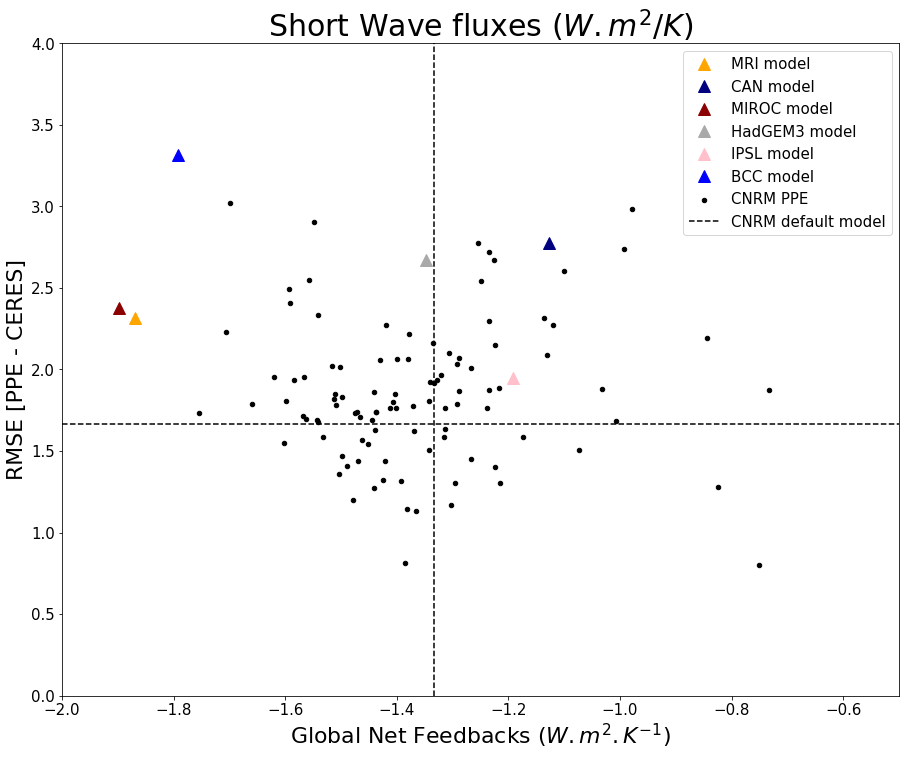

In [70]:
ax = plt.gca()

E_PPE_df.plot(kind='scatter', x='Fdbck', y='E_PPE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)
plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)


plt.hlines(E_p1,xmin = -2.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = 0,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')

legend = ['MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model',
          'BCC model', 'CNRM PPE', 'CNRM default model']

title = TITLE
plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(title, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0,4)
plt.xlim(-2.0,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

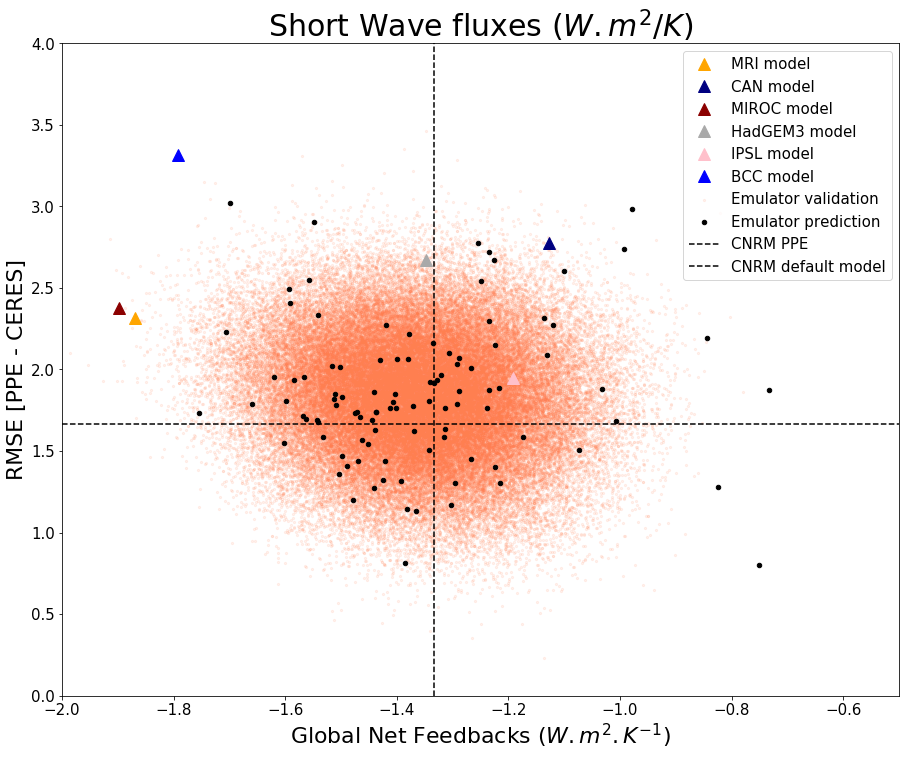

In [71]:
ax = plt.gca()

plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

#E_multilinreg_val_df.plot(kind='scatter', x='Fdbck_val', y='E_multilinreg_val', color='red', alpha=1, figsize=(15, 12), 
#                     marker='x', ax = ax)
E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='coral', alpha=0.1, figsize=(15, 12), marker='.', ax = ax)


E_PPE_df.plot(kind='scatter', x='Fdbck', y='E_PPE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -2.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = 0,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')

legend = ['MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model',
          'BCC model', 'Emulator validation', 'Emulator prediction', 'CNRM PPE', 'CNRM default model']

title = TITLE
plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(title, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(0,4)
plt.xlim(-2.0,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_pred.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

In [23]:
fluxes_biases = E_PPE_df
fluxes_biases['E_multilinreg_val'] = E_multilinreg_val_df['E_multilinreg_val']
fluxes_biases['OSE_multilinreg'] = abs(fluxes_biases['E_PPE'] - fluxes_biases['E_multilinreg_val'])
fluxes_biases

,E_PPE,Fdbck,E_multilinreg_val,OSE_multilinreg
0,1.277445,-0.825236,1.357486,0.080040
1,1.789840,-1.659636,1.773526,0.016314
2,1.302026,-1.215000,1.237071,0.064956
3,1.963318,-1.321641,1.838836,0.124482
4,0.802075,-0.750397,0.987802,0.185727
...,...,...,...,...
97,2.020377,-1.516367,1.650842,0.369534
98,1.933462,-1.584491,1.911816,0.021646
99,1.733249,-1.474525,1.900148,0.166898
100,1.691045,-1.445422,1.718834,0.027789


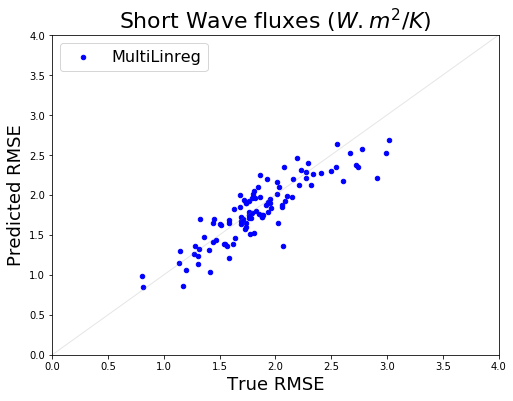

In [73]:
plt.subplots(figsize=(8,20))

#########################
plt.subplot(311)
ax = plt.gca()

title= TITLE 
fluxes_biases.plot(kind='scatter', x='E_PPE', y='E_multilinreg_val', color='blue',  
                     marker="o", ax = ax)
#fluxes_biases.plot(kind='scatter', x='E_PPE', y='E_lasso_val', color='blue', alpha=0.6, 
#                     marker="o", ax = ax)

plt.xlabel('True RMSE', fontsize = 18)#, fontsize=18)
plt.ylabel('Predicted RMSE', fontsize = 18)#, fontsize=18)
plt.legend(['MultiLinreg', 'LASSO'], fontsize = 16)
plt.title(title, fontsize = 22)#, fontsize=22)
plt.ylim(0,4)
plt.xlim(0,4)
ax.plot((0, 4), (0, 4), linewidth=1.0, color='gray', alpha=0.2)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/"+variable+"_emulator_skill.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

### Save data 

In [24]:
OSE = fluxes_biases['OSE_multilinreg'].mean()
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/OSE_'+variable+'.npy', OSE)
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable+'.npy', E_p1)

In [75]:
RMSE_val = fluxes_biases['E_multilinreg_val']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_val_'+variable+'.npy', RMSE_val)

In [76]:
## SAVE 
E_multilinreg_pred = E_multilinreg_pred_df['E_multilinreg_pred'].values
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_'+variable+'.npy', E_multilinreg_pred)

E_PPE = E_PPE_df['E_PPE'].values
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy', E_PPE)

### [Back to the top](#top)

# <a id="histograms">Figure histograms</a> </li>

In [5]:
E_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable+'.npy')
p1_feedback = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')
Fdbck_CFMIP = np.load(file='/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/CMIP6_NetFeedbcks.npy')
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")

In [6]:
E_MLR = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_'+variable+'.npy')
Fdbck_MLR = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")
MLR_df=pd.DataFrame(E_MLR, columns=['E_MLR'])
MLR_df['Fdbck'] = Fdbck_MLR
MLR_df

,E_MLR,Fdbck
0,1.452420,-1.499698
1,2.090596,-1.339351
2,1.715070,-1.323732
3,1.563995,-1.541909
4,1.646913,-1.346961
...,...,...
99995,2.578970,-1.453679
99996,2.084024,-1.410350
99997,1.277945,-1.296397
99998,1.365484,-1.299809


In [7]:
E_MLR_short = []
tmp = []
Fdbck_MLR_short = []
cpt=0

for i in MLR_df['E_MLR']:
    if i <= E_p1:
        E_MLR_short.append(i)
        toto = MLR_df['Fdbck'][cpt]
        Fdbck_MLR_short.append(toto)
        cpt+=1
        
    else:
        tmp.append(i)
        cpt+=1

MLR_short = pd.DataFrame()
MLR_short['Fdbck'] = Fdbck_MLR_short
MLR_short['E_MLR'] = E_MLR_short
MLR_short

,Fdbck,E_MLR
0,-1.499698,1.452420
1,-1.541909,1.563995
2,-1.346961,1.646913
3,-1.133599,1.598920
4,-1.118548,1.252026
...,...,...
32445,-1.435430,1.505461
32446,-1.290641,0.641137
32447,-1.394434,1.641818
32448,-1.296397,1.277945


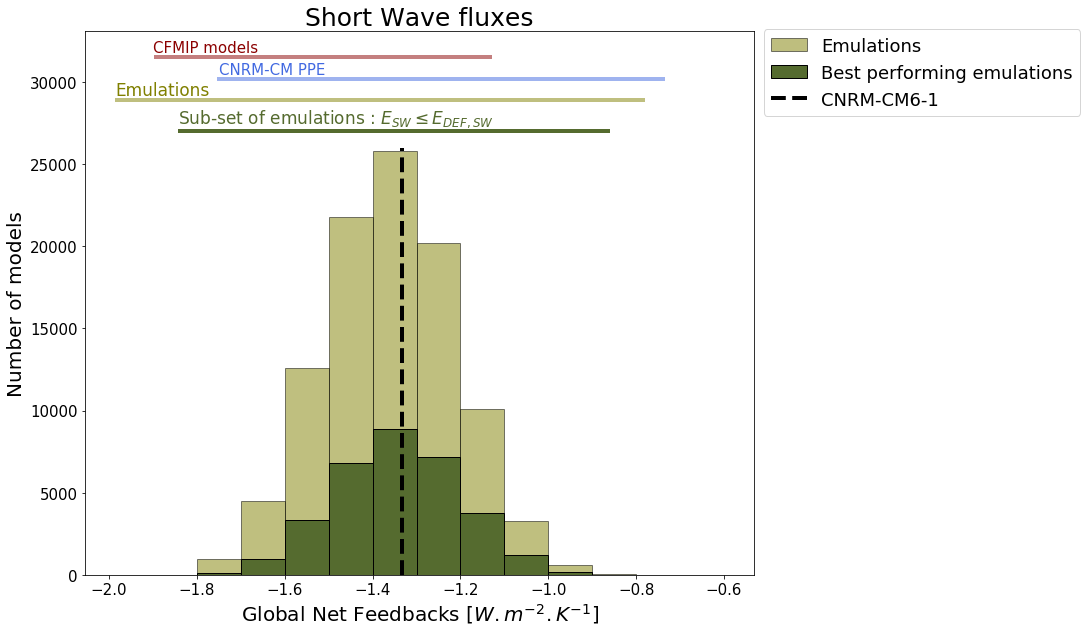

In [12]:
fig, ax = plt.subplots(figsize=(12,10))

Bins = [-1.8,-1.7,-1.6,-1.5,-1.4,-1.3,-1.2,-1.1,-1.0,-0.9,-0.8,-0.7,-0.6]

ax = sns.distplot(Fdbck_MLR, norm_hist=False, bins = Bins, kde = False, 
                  hist_kws={"alpha": 0.5, "color" : 'olive', "edgecolor" : "black"}, 
                  label = 'Emulator', ax=ax)

ax = sns.distplot(MLR_short['Fdbck'], norm_hist=False, bins = Bins, kde = False, 
                 hist_kws={"alpha": 1.0, "color" : 'darkolivegreen', "edgecolor" : "black"}, 
                  label= 'Selected emulations', ax=ax)

#ax = sns.distplot(Fdbck_PPE, norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 1.0, "color" : 'blue', "edgecolor" : "black"}, 
#                  label = 'PPE', ax=ax)

#ax = sns.distplot(PPE_short_df['Fdbck'], norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 0.8, "color" : 'navy', "edgecolor" : "black"}, 
#                  label = 'Best PPE members', ax=ax)

plt.vlines(p1_feedback,ymin = 0,ymax = 26000,label='CNRM default model', colors='black', linewidth=4.0,
           linestyles='dashed')

plt.hlines(31500.0,xmin = Fdbck_CFMIP.min(),xmax = Fdbck_CFMIP.max(),
           colors='darkred',alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.9, 31800.0, 'CFMIP models', color = 'darkred', fontsize=15)

plt.hlines(30200.0,xmin = Fdbck_PPE.min(),xmax = Fdbck_PPE.max(),
           colors='royalblue', alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.75, 30500.0, 'CNRM-CM PPE', color = 'royalblue', fontsize=15)

plt.hlines(28900.0,xmin = Fdbck_MLR.min(),xmax = Fdbck_MLR.max(),
           colors='olive', alpha=0.5,linewidth=4.0, linestyles='solid')
plt.text(Fdbck_MLR.min(), 29200.0, 'Emulations', color = 'olive', fontsize=17)

plt.hlines(27000.0,xmin = MLR_short['Fdbck'].min(),xmax = MLR_short['Fdbck'].max(),
           colors='darkolivegreen', linewidth=4.0, linestyles='solid')
plt.text(MLR_short['Fdbck'].min(), 27500.0, 'Sub-set of emulations : $E_{SW}\leq E_{DEF,SW}$', 
         color = 'darkolivegreen', fontsize=17)

legend=['Emulations', 'Best performing emulations', 'CNRM-CM6-1']
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, bbox_to_anchor=(1.5, 1.02))
plt.title(TITLE, fontsize = 25)
plt.xlabel('Global Net Feedbacks [$W.m^{-2}.K^{-1}$]',fontsize=20)
plt.ylabel('Number of models',fontsize=20)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/"+variable+"_threshold_feedbacks.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

In [13]:
E_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy')
PPE_df=pd.DataFrame(E_PPE, columns=['E_PPE'])
PPE_df['Fdbck'] = Fdbck_PPE
#PPE_df

In [14]:
E_PPE_short = []
tmp = []
Fdbck_PPE_short = []
cpt=0

for i in PPE_df['E_PPE']:
    if i <= E_p1:
        E_PPE_short.append(i)
        toto = PPE_df['Fdbck'][cpt]
        Fdbck_PPE_short.append(toto)
        cpt+=1
        
    else:
        tmp.append(i)
        cpt+=1

PPE_short = pd.DataFrame()
PPE_short['Fdbck'] = Fdbck_PPE_short
PPE_short['E_PPE'] = E_PPE_short
#PPE_short

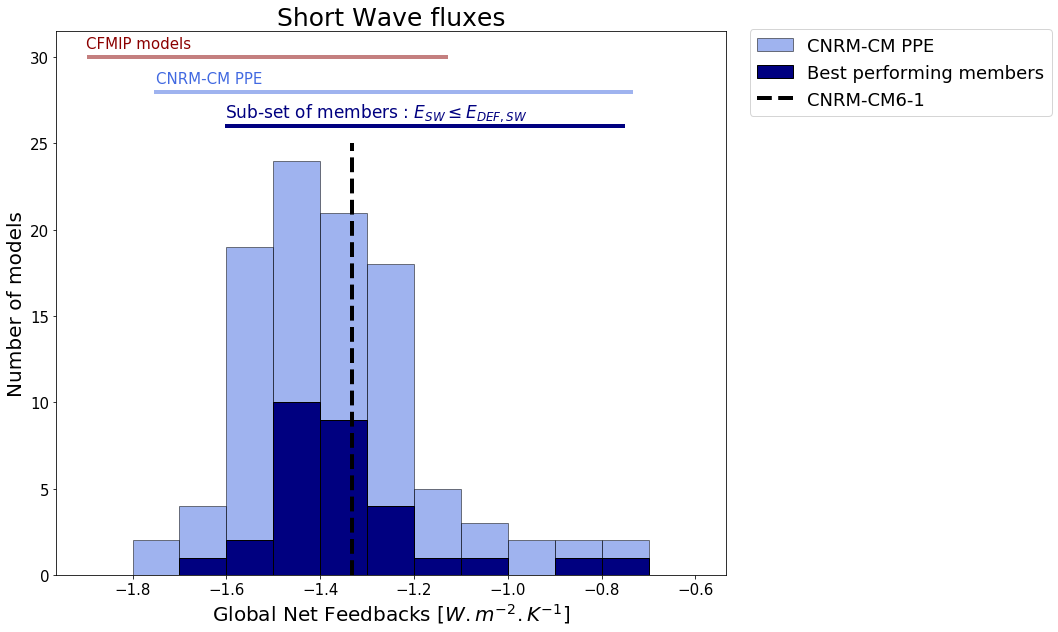

In [15]:
fig, ax = plt.subplots(figsize=(12,10))

Bins = [-1.8,-1.7,-1.6,-1.5,-1.4,-1.3,-1.2,-1.1,-1.0,-0.9,-0.8,-0.7,-0.6]

ax = sns.distplot(Fdbck_PPE, norm_hist=False, bins = Bins, kde = False, 
                  hist_kws={"alpha": 0.5, "color" : 'royalblue', "edgecolor" : "black"}, 
                  label = 'Emulator', ax=ax)

ax = sns.distplot(PPE_short['Fdbck'], norm_hist=False, bins = Bins, kde = False, 
                 hist_kws={"alpha": 1.0, "color" : 'navy', "edgecolor" : "black"}, 
                  label= 'Selected emulations', ax=ax)

#ax = sns.distplot(Fdbck_PPE, norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 1.0, "color" : 'blue', "edgecolor" : "black"}, 
#                  label = 'PPE', ax=ax)

#ax = sns.distplot(PPE_short_df['Fdbck'], norm_hist= False, bins = Bins, kde = False, 
#                  hist_kws={"alpha": 0.8, "color" : 'navy', "edgecolor" : "black"}, 
#                  label = 'Best PPE members', ax=ax)

plt.vlines(p1_feedback,ymin = 0,ymax = 25,label='CNRM default model', colors='black', linewidth=4.0,
           linestyles='dashed')

plt.hlines(30.0,xmin = Fdbck_CFMIP.min(),xmax = Fdbck_CFMIP.max(),
           colors='darkred',alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.9, 30.5, 'CFMIP models', color = 'darkred', fontsize=15)

plt.hlines(28.0,xmin = Fdbck_PPE.min(),xmax = Fdbck_PPE.max(),
           colors='royalblue', alpha=0.5, linewidth=4.0, linestyles='solid')
plt.text(-1.75, 28.5, 'CNRM-CM PPE', color = 'royalblue', fontsize=15)

#plt.hlines(28900.0,xmin = Fdbck_MLR.min(),xmax = Fdbck_MLR.max(),
#           colors='olive', alpha=0.5,linewidth=4.0, linestyles='solid')
#plt.text(Fdbck_MLR.min(), 29200.0, 'Emulations', color = 'olive', fontsize=17)

plt.hlines(26.0,xmin = PPE_short['Fdbck'].min(),xmax = PPE_short['Fdbck'].max(),
           colors='navy', linewidth=4.0, linestyles='solid')
plt.text(PPE_short['Fdbck'].min(), 26.5, 'Sub-set of members : $E_{SW}\leq E_{DEF,SW}$', 
         color = 'navy', fontsize=17)

legend=['CNRM-CM PPE', 'Best performing members', 'CNRM-CM6-1']
ax.tick_params(axis='both', which='major', labelsize=15)
plt.legend(legend, fontsize=18, bbox_to_anchor=(1.5, 1.02))
plt.title(TITLE, fontsize = 25)
plt.xlabel('Global Net Feedbacks [$W.m^{-2}.K^{-1}$]',fontsize=20)
plt.ylabel('Number of models',fontsize=20)

# Enregistrer la figure ...........

plt.savefig("/data/home/globc/peatier/figures/PPE_"+variable+"_threshold_feedbacks.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Display the figure 
plt.show()

### [Back to the top](#top)

# <a id="optim">Step 5 - Optimisation</a> </li>

The objective here is to optimize the emulators described above in order to obtain a sub-set of the best parametrizations for each bins of feedback values. In other words, we aim to fine the parametrization which minimizes the error $E_{tot}$ given by the control mean state emulator, while showing a global net feedback value predicted by the feedback emulator within a chosen bin. It is a case of linear minimization with constraint and the optimizer used here comes from the SciPy Python's library and uses sequential least squares programming (SLSQP).

### Functions 

In [14]:
def MultiLinReg_pred(x, EOF_nb, variable) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta'+str(EOF_nb)+'.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R'+str(EOF_nb)+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

def Error_emulator(pc1, pc2, pc3, pc4, pc5, variable):
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/5)
    return E

In [15]:
# FONCTIONS RMSE

def function_RMSE_emulator_std(x, variable): 
    #mean = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_mean.npy')
    #std = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_std.npy')
    #x_std = (x-mean)/std
    pc1 = MultiLinReg_pred(x, 1, variable)
    pc2 = MultiLinReg_pred(x, 2, variable)
    pc3 = MultiLinReg_pred(x, 3, variable)
    pc4 = MultiLinReg_pred(x, 4, variable)
    pc5 = MultiLinReg_pred(x, 5, variable)
    
    E = Error_emulator(pc1, pc2, pc3, pc4, pc5, variable)
    
    #E = sqrt(tmp_E)
    
    return E

def function_RMSE_emulator(x, variable): 
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_RMSE_emulator_std(x_std, variable)
    return E

# FONCTIONS FEEDBACKS

def em_fdb_std(x) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file = "/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")

    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred

def em_fdb(x) :
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    y_pred = em_fdb_std(x_std)
    return y_pred

In [16]:
# FONCTION JACOBIAN

def jacobian(x, variable) :
    
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    
    Beta1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta1.npy')
    Beta2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta2.npy')
    Beta3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta3.npy')
    Beta4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta4.npy')
    Beta5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta5.npy')
    
    R1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R1.npy')
    R2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R2.npy')
    R3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R3.npy')
    R4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R4.npy')
    R5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R5.npy')
    
    C1 = R1 - U_obs[0]
    C2 = R2 - U_obs[1]
    C3 = R3 - U_obs[2]
    C4 = R4 - U_obs[3]
    C5 = R5 - U_obs[4]
    
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    A = x_std*(Beta1**2 + Beta2**2 + Beta3**2 + Beta4**2 + Beta5**2) + (Beta1*C1 + Beta2*C2 + Beta3*C3 + 
                                                                    Beta4*C4 + Beta5*C5)
    
    tmp = x_std**2*(Beta1**2 + Beta2**2 + Beta3**2 + Beta4**2 + Beta5**2) + 2*x_std*(Beta1*C1 + Beta2*C2 + Beta3*C3 + Beta4*C4 + Beta5*C5) +(C1**2+C2**2+C3**2+C4**2+C5**2)
    B = sqrt(tmp)
    
    D = 1/sqrt(5)
    
    jac = (A/B)*D
    
    return jac


# FONCTIONS CONTRAINTES

def constraint1(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (tmp-fdb_low)
    return test

def constraint2(x, fdb_low, fdb_hi):
    tmp = (em_fdb(x))
    low = (fdb_low)
    hi = (fdb_hi)
    test = (fdb_hi-tmp)
    return test


# FONCTIONS OPTIMISATION

def Optimization(x_best, ind, xlim, variable) :
    
    sol_list=[]
    sol_fdbck=[]
    sol_x=[]
    n = len(x_best)
    cpt=0
    
    for i in range(0, n, 1) :
        x0 = x_best[i]
   
        fdb_low = em_fdb(x0)-ind
        #print('low = '+str(fdb_low))
        fdb_hi = em_fdb(x0)+ind
        #print('hi = '+str(fdb_hi))

        fdb_x0 = em_fdb(x0)
        #print('fdb_x0 = '+str(fdb_x0))
        fun_x0 = function_RMSE_emulator(x0, variable)
        #print('fun_x0 = '+str(fun_x0))

        cons1 = {'type': 'ineq', 'fun' : constraint1, 'args' : [fdb_low, fdb_hi]}
        cons2 = {'type': 'ineq', 'fun' : constraint2, 'args' : [fdb_low, fdb_hi]}
    
        sol = minimize(function_RMSE_emulator,  x0, args=(variable), method='SLSQP', bounds=xlim, constraints=(cons1, cons2), 
                   jac = jacobian, options={'disp': True}, tol = 0.001)    
                        # , 'maxiter' : 250   jac = jacobian,
    

        tmp_fun = function_RMSE_emulator(sol.x, variable)
        tmp_fdbck = em_fdb(sol.x)
        #print('fdb_x = '+str(tmp_fdbck))
    
        sol_list.append(tmp_fun)
        sol_fdbck.append(tmp_fdbck)
        sol_x.append(sol.x)
    
    sol_df = pd.DataFrame()
    sol_df['sol_fun'] = sol_list[:]
    sol_df['Fdbck'] = sol_fdbck[:]
    j=1
    for i in range(0, 30, 1) :
        #print(j)
        sol_df['x'+str(j)+'_smth_0'] = (transpose(sol_x)[i])
        j+=1
    
    return sol_df

In [17]:
def smooth(n, df1, df2):

    for i in range(1,31,1) :
        tmp_x =[df1['x'+str(i)+'_smth_'+str(n-1)][0]]

        for j in range(1,len(df1)-1, 1) : 
            tmp = 0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j-1]+0.5* \
            df1['x'+str(i)+'_smth_'+str(n-1)][j]+0.25*df1['x'+str(i)+'_smth_'+str(n-1)][j+1]
            
            tmp_x.append(tmp)
    
        tmp_x.append(df1['x'+str(i)+'_smth_'+str(n-1)][(len(df1)-1)])
        
        df2['x'+str(i)+'_smth_'+str(n)] = tmp_x

    return df2

### Get the data

In [18]:
E_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable+'.npy')
E_p1

array(1.664249)

In [19]:
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
E_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy')

E_PPE_df = pd.DataFrame()
E_PPE_df['Fdbck'] = Fdbck_PPE
E_PPE_df['RMSE'] = E_PPE
E_PPE_df

,Fdbck,RMSE
0,-0.825236,1.277445
1,-1.659636,1.789840
2,-1.215000,1.302026
3,-1.321641,1.963318
4,-0.750397,0.802075
...,...,...
97,-1.516367,2.020377
98,-1.584491,1.933462
99,-1.474525,1.733249
100,-1.445422,1.691045


In [20]:
E_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_multilinreg_pred_"+variable+".npy")
Fdbck_multilinreg_pred = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/MultiLinReg_prediction_FdbckN.npy")


E_multilinreg_pred_df = pd.DataFrame(E_multilinreg_pred)
E_multilinreg_pred_df['E_multilinreg_pred'] = E_multilinreg_pred
E_multilinreg_pred_df['Fdbck_pred'] = Fdbck_multilinreg_pred[0:100000]
E_multilinreg_pred_df = E_multilinreg_pred_df.drop([0], axis=1)
E_multilinreg_pred_df

,E_multilinreg_pred,Fdbck_pred
0,1.452420,-1.499698
1,2.090596,-1.339351
2,1.715070,-1.323732
3,1.563995,-1.541909
4,1.646913,-1.346961
...,...,...
99995,2.578970,-1.453679
99996,2.084024,-1.410350
99997,1.277945,-1.296397
99998,1.365484,-1.299809


### Initial guess for Optimization 1

In [21]:
E_multilinreg_pred_df['Fdbck_pred_round'] = E_multilinreg_pred_df['Fdbck_pred'].round(decimals=2)
E_multilinreg_pred_df = E_multilinreg_pred_df.set_index('Fdbck_pred_round')
E_multilinreg_pred_df['members'] = range(0,100000,1) 
#E_multilinreg_pred_df        

In [22]:
new_df=pd.DataFrame()
new_df['E_multilinreg_pred_best'] = E_multilinreg_pred_df['E_multilinreg_pred'].groupby('Fdbck_pred_round').min()
new_df = new_df.reset_index()
#new_df

In [23]:
list_RMSE = new_df['E_multilinreg_pred_best']
n = len(list_RMSE)

tmp_fdbck = []
tmp_member = []
tmp_pc1 = []
cpt=0
ind=0
cpt_other=0
for i in E_multilinreg_pred_df['E_multilinreg_pred'] :
    for j in list_RMSE :
        if i==j:
            #print(cpt)
            tmp_fdbck.append(E_multilinreg_pred_df['Fdbck_pred'].iloc[cpt])
            tmp_member.append(E_multilinreg_pred_df['members'].iloc[cpt])
        else :
            cpt_other+=1
    cpt+=1

fdbck = [k for k in tmp_fdbck if k != 0]
members = [l for l in tmp_member if l != 0]
pc1 = [l for l in tmp_pc1 if l != 0]

df = pd.DataFrame()
df['fdbck'] = fdbck
df['members'] = members
df_sort = df.sort_values(by=['fdbck']).reset_index().drop('index', axis=1)
df_sort

new_df['Fdbck_pred'] = df_sort['fdbck']
new_df['members'] = df_sort['members']
#new_df

### Optimization 1 

In [24]:
LHS = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_param.npy")

x_best = []
for i in new_df['members']:
    #print(i)
    x_best.append(LHS[i])

x_best=np.array(x_best)
#x_best

In [25]:
param = pd.read_csv("/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/csv/param.csv",sep=' ', header=None)
param_int = param.set_index(0).transpose()
param_names = param[0]

N=len(param_names)
xlimits=[[1,1]]*N
i=0
while i<N:
    name = param_names[i]
    xmin = param_int[name].iloc[0]
    xmax = param_int[name].iloc[1]
    if xmin<xmax:
        limit = [xmin, xmax]
    else:
        limit = [xmax, xmin]
    xlimits[i] = limit
    i+=1
    
xlim = np.array(xlimits)
#xlim

In [26]:
sol_df = Optimization(x_best, 0.0001, xlim, variable)
#sol_df

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.4100302572444388
            Iterations: 3
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2658557634602094
            Iterations: 3
            Function evaluations: 14
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1716294860475567
            Iterations: 3
            Function evaluations: 15
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.6074519903102915
            Iterations: 4
            Function evaluations: 15
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.7962608769601198
            Iterations: 7
            Function evaluat

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.6325670032147602
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.4555737278112953
            Iterations: 4
            Function evaluations: 17
            Gradient evaluations: 4
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.46147357870495986
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.46189009703502265
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.3812577339105628
            Iterations: 4
            Function evalu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.17959865280987378
            Iterations: 3
            Function evaluations: 11
            Gradient evaluations: 3
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5118130695790775
            Iterations: 2
            Function evaluations: 13
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.30300748998309135
            Iterations: 5
            Function evaluations: 21
            Gradient evaluations: 5
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.47758219001979463
            Iterations: 2
            Function evaluations: 13
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2120841989736636
            Iterations: 3
            Function eval

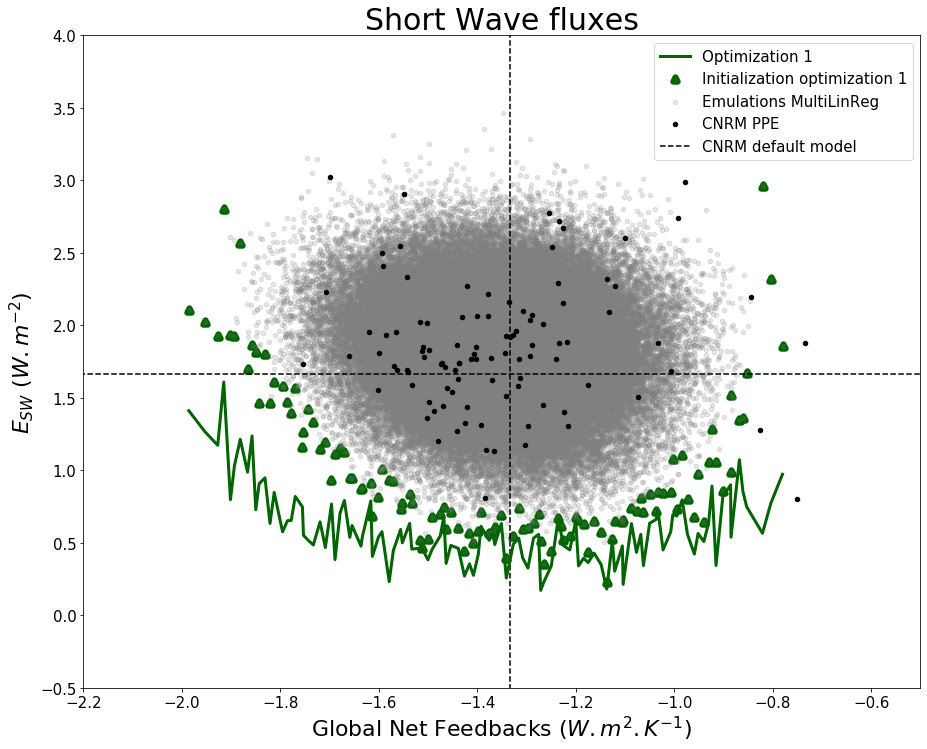

In [119]:
ax = plt.gca()

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='darkgray', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_IPSL, E_IPSL, color='pink', marker='^', linewidth=0, markersize=12)
#plt.plot(Fdbck_BCC, E_BCC, color='blue', marker='^', linewidth=0, markersize=12)

new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', 
         marker = '^', linewidth=6,  ax = ax)

sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', 
         linewidth=3, ax = ax)

E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE', color='black', figsize=(15, 12), 
                     marker="o", ax = ax)



plt.hlines(E_p1,xmin = -4.0,xmax = 2.0,label='default simulation', colors='black', 
           linestyles='dashed')
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed')


#'MRI model', 'CAN model', 'MIROC model', 'HadGEM3 model', 'IPSL model','BCC model', 
legend = ['Optimization 1', 'Initialization optimization 1', 'Emulations MultiLinReg', 'CNRM PPE', 'CNRM default model']

plt.xlabel('Global Net Feedbacks ($W.m^2.K^{-1}$)', fontsize=22)
plt.ylabel(ylabel, fontsize=22)
plt.legend(legend, fontsize=15)
plt.title(TITLE, fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.ylim(-0.5,4)
plt.xlim(-2.2,-0.5)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_optim1.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Initial guess for Optimization 2 (param. moothing)

In [27]:
new_sol_df = pd.DataFrame()
new_sol_df['Fdbck'] = sol_df['Fdbck']

new_sol_df = smooth(1, sol_df, new_sol_df)

n = 151
for i in range(2,n,1) :
    new_sol_df = smooth(i, new_sol_df, new_sol_df)
    
new_sol_df

,Fdbck,x1_smth_1,x2_smth_1,x3_smth_1,x4_smth_1,x5_smth_1,x6_smth_1,x7_smth_1,x8_smth_1,x9_smth_1,...,x21_smth_150,x22_smth_150,x23_smth_150,x24_smth_150,x25_smth_150,x26_smth_150,x27_smth_150,x28_smth_150,x29_smth_150,x30_smth_150
0,-1.985856,0.184034,1.221701,2.152209,29.684905,-0.010000,8.417909,2.937830,0.005683,0.000482,...,-2.634078,-25.503514,0.100000,13.999898,0.00001,0.836420,0.726625,0.500000,0.500000,6.246846
1,-1.953241,0.230290,1.104708,2.039727,23.470099,-0.010000,7.524774,3.896736,0.007602,0.000765,...,-2.738771,-26.603487,0.100000,13.997185,0.00001,0.814589,0.747561,0.501327,0.500047,6.225105
2,-1.927100,0.197841,1.274944,1.596614,22.602424,-0.010000,7.398333,2.218247,0.004991,0.000788,...,-2.843265,-27.689461,0.099999,13.993283,0.00001,0.793011,0.768244,0.502649,0.500099,6.204611
3,-1.914873,0.137778,1.995257,1.329362,20.185535,-0.010000,5.975633,0.468102,0.001559,0.000894,...,-2.947355,-28.748115,0.099999,13.987008,0.00001,0.771925,0.788429,0.503962,0.500160,6.186560
4,-1.901309,0.111905,2.607872,1.145349,18.978642,-0.010000,3.472368,0.133041,0.001511,0.001000,...,-3.050815,-29.767441,0.099998,13.977191,0.00001,0.751557,0.807892,0.505261,0.500235,6.172042
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,-0.860471,0.252770,2.679838,1.436202,7.178118,-0.224374,2.255663,5.446646,0.010000,0.000050,...,-3.099498,-45.913174,0.028690,8.888444,0.00010,0.537408,0.749807,0.611680,0.540980,7.083467
109,-0.852841,0.266837,2.715736,1.268654,12.489266,-0.086674,1.217357,5.786031,0.010000,0.000050,...,-3.051829,-46.388072,0.024218,9.038485,0.00010,0.528090,0.751688,0.602523,0.531307,7.332837
110,-0.820749,0.278725,2.700674,1.127327,16.888417,-0.010000,0.287865,4.384806,0.010000,0.000050,...,-3.003057,-46.891446,0.019577,9.191544,0.00010,0.518743,0.753604,0.592970,0.521150,7.597433
111,-0.803575,0.279673,2.680704,1.218582,21.646023,-0.010000,0.329160,4.042087,0.010000,0.000050,...,-2.953553,-47.414486,0.014818,9.346717,0.00010,0.509376,0.755540,0.583145,0.510660,7.872535


In [ ]:
# SETTINGS ------------------

n = 150

colors = ['black', 'green', 'orange', 'red', 'blue', 'yellow', 'coral', 'pink', 'purple', 'white','red']*100

# Plot of lines from different dataframes
plt.subplots(figsize=(15,10)) 

plt.subplot(331)

ax1 = plt.gca()
title = 'parameter 1'

sol_df.plot(kind='line', x='Fdbck', y='x1_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax1)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x1_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax1)

plt.xlim(-2.2,-0.5)
plt.legend(['x1', 'x1_smth_1'])
plt.subplot(332)

ax2 = plt.gca()
title = 'parameter 2'

sol_df.plot(kind='line', x='Fdbck', y='x2_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax2)
for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x2_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax2)

plt.xlim(-2.2,-0.5)
plt.legend(['x2', 'x2_smth_1'])
plt.subplot(333)

ax3 = plt.gca()
title = 'parameter 3'

sol_df.plot(kind='line', x='Fdbck', y='x3_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax3)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x3_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax3)

plt.xlim(-2.2,-0.5)
plt.legend(['x3', 'x3_smth_1'])
plt.subplot(334)

ax4 = plt.gca()
title = 'parameter 4'

sol_df.plot(kind='line', x='Fdbck', y='x4_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax4)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x4_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax4)

plt.xlim(-2.2,-0.5)
plt.legend(['x4', 'x4_smth_1'])
plt.subplot(335)

ax5 = plt.gca()
title = 'parameter 5'

sol_df.plot(kind='line', x='Fdbck', y='x5_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax5)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x5_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax5)

plt.xlim(-2.2,-0.5)
plt.legend(['x5', 'x5_smth_1'])
plt.subplot(336)

ax6 = plt.gca()
title = 'parameter 6'

sol_df.plot(kind='line', x='Fdbck', y='x6_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax6)

for i in range(1,n,1) : 
    new_sol_df.plot(kind='line', x='Fdbck', y='x6_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax6)
    
plt.xlim(-2.2,-0.5)
plt.legend(['x6', 'x6_smth_1'])
plt.subplot(337)

ax7 = plt.gca()
title = 'parameter 7'

sol_df.plot(kind='line', x='Fdbck', y='x7_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax7)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x7_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax7)

plt.xlim(-2.2,-0.5)
plt.legend(['x7', 'x7_smth_1'])
plt.subplot(338)

ax8 = plt.gca()
title = 'parameter 8'

sol_df.plot(kind='line', x='Fdbck', y='x8_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax8)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x8_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax8)

plt.ylim(-0.005,0.0125)
plt.xlim(-2.2,-0.5)
plt.legend(['x8', 'x8_smth_1'])
plt.subplot(339)

ax9 = plt.gca()
title = 'parameter 9'

sol_df.plot(kind='line', x='Fdbck', y='x9_smth_0', color = 'black', 
         marker = '^', linewidth=1.5, ax=ax9)

for i in range(1,n,1) :
    new_sol_df.plot(kind='line', x='Fdbck', y='x9_smth_'+str(i), color = colors[i], linewidth=2.0, ax=ax9)

plt.ylim(-0.0001,0.0015)
plt.xlim(-2.2,-0.5)
plt.legend(['x9', 'x9_smth_1'])

#Ajustement des subplots
plt.tight_layout()
plt.subplots_adjust(hspace = 0.30)

# Enregistrer la figure .....................

#plt.savefig("/data/home/globc/peatier/figures/longPPE_N_tas_future4K.png", 
#        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Optimization 2

In [28]:
x_best_2 = pd.DataFrame()
for k in range(1,31,1) : 
    x_best_2['x'+str(k)+'_best'] = new_sol_df['x'+str(k)+'_smth_150']

x_best_2 = x_best_2.to_numpy()
x_best_2

array([[0.18403395, 1.2217009 , 2.15220893, ..., 0.5       , 0.5       ,
        6.24684596],
       [0.18159673, 1.31998411, 2.0772182 , ..., 0.50132741, 0.50004711,
        6.22510526],
       [0.17923701, 1.41718736, 2.0028572 , ..., 0.50264948, 0.50009881,
        6.20461148],
       ...,
       [0.2716932 , 2.66769304, 1.11945262, ..., 0.59297017, 0.52115035,
        7.59743292],
       [0.27582509, 2.69673253, 1.11449865, ..., 0.58314529, 0.51066013,
        7.87253479],
       [0.28      , 2.72595089, 1.10980489, ..., 0.57318131, 0.5       ,
        8.15299829]])

In [29]:
init_df = pd.DataFrame()
init_df['Fdbck'] = sol_df['Fdbck']

tmp_fun = []
for i in x_best_2 :
    tmp = function_RMSE_emulator(i, variable)
    tmp_fun.append(tmp)
init_df['RMSE'] = tmp_fun
init_df

,Fdbck,RMSE
0,-1.985856,1.410030
1,-1.953241,1.345227
2,-1.927100,1.281592
3,-1.914873,1.219529
4,-1.901309,1.159366
...,...,...
108,-0.860471,0.791816
109,-0.852841,0.834770
110,-0.820749,0.879322
111,-0.803575,0.925109


In [30]:
sol_df_2 = Optimization(x_best_2, 0.0001, xlim, variable)
#sol_df_2

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.2715703971436487
            Iterations: 2
            Function evaluations: 13
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1985810148287142
            Iterations: 2
            Function evaluations: 13
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1362169751638131
            Iterations: 2
            Function evaluations: 13
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.21193152618722
            Iterations: 2
            Function evaluations: 14
            Gradient evaluations: 2
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1.1524411883602887
            Iterations: 2
            Function evaluatio

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2867292464480195
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.28003258396894787
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.27405200707308885
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.26881337643991954
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2643298482321549
            Iterations: 1
            Function eval

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2592904767991734
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2615905928194404
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.2653468543192995
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.27061357677006614
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.27739111359564406
            Iterations: 1
            Function evalu

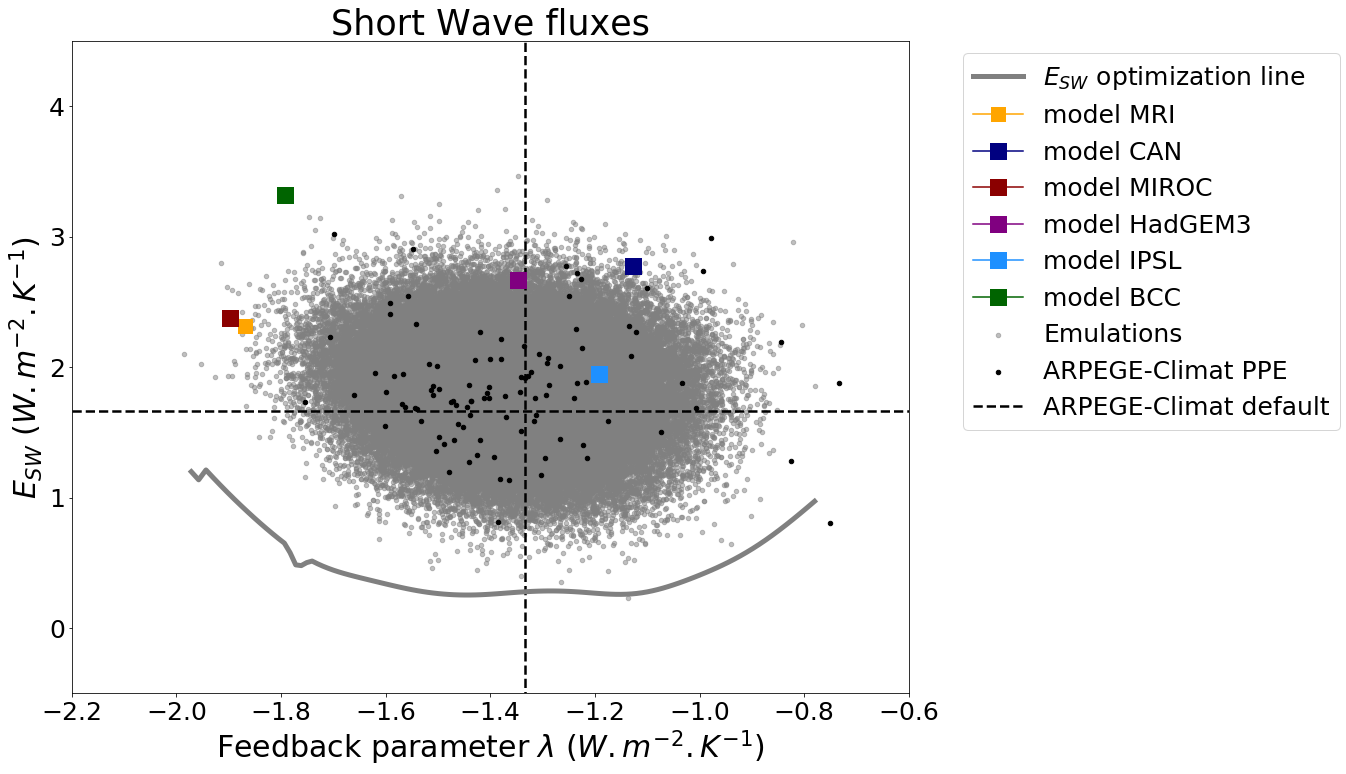

In [56]:
colors = ['coral','blue','orange','black','green','red','purple','yellow','cornflowerblue']
cpt=0

ax = plt.gca()

#new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', alpha=0.3,
#         marker = '^', linewidth=6,  ax = ax)

#init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkgreen', alpha=1,
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', alpha=0.3,
#         linewidth=3, ax = ax)

sol_df_2[1:].plot(kind='line', x='Fdbck', y='sol_fun', color = 'gray', alpha=1, linewidth=5, ax = ax)

E_multilinreg_pred_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred', 
                           color='gray', alpha=0.5, figsize=(15, 12), marker='o', ax = ax)

E_PPE_df.plot(kind='scatter', x='Fdbck', y='RMSE', color='black', figsize=(15, 12), alpha=1.0,
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)

plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='s', markeredgewidth=0, markersize=15, zorder=20)
plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='s', markeredgewidth=2, markersize=15, zorder=30)
plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='purple', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_IPSL, E_IPSL, color='dodgerblue', marker='s', markeredgewidth=2, markersize=15, zorder=20)
plt.plot(Fdbck_BCC, E_BCC, color='darkgreen', marker='s', markeredgewidth=2, markersize=15, zorder=20)


legend = ['$E_{SW}$ optimization line', 'model MRI','model CAN','model MIROC','model HadGEM3','model IPSL', 'model BCC', 
          'Emulations','ARPEGE-Climat PPE', 'ARPEGE-Climat default']
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=30)
plt.ylabel(ylabel, fontsize=30)
plt.legend(legend, fontsize=25, bbox_to_anchor=(1.05, 1))

plt.title(TITLE, fontsize=35)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.ylim(-0.5,4.5)
plt.xlim(-2.2,-0.6)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_optim2.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Save data

In [32]:
RMSE_optim2 = sol_df_2['sol_fun']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+variable+'.npy', RMSE_optim2)

Fdbck_optim2 = sol_df_2['Fdbck']
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+variable+'.npy', Fdbck_optim2)

### [Back to the top](#top)

# <a id="selection">Step 6 - Optimal subset of parameters</a> </li>

## Projection of sub-set on EOF basis

### Settings 

In [16]:
ENSEMBLE = 'ENSEMBLE4_selection/'
path_PPE_short = '/data/scratch/globc/peatier/CNRM-CM6-1_PPE/'
product = 'CERES'

In [17]:
nb_p_list_LHS500 = ['p810', 'p812', 'p813', 'p814','p815', 'p816', 'p817']
len(nb_p_list_LHS500)

7

### Functions

In [18]:
def Error_emulator(pc1, pc2, pc3, pc4, pc5, variable):
    U_obs = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/U_obs_'+variable+'.npy')
    E_tmp = (pc1-U_obs[0])**2 + (pc2-U_obs[1])**2 + (pc3-U_obs[2])**2 + (pc4-U_obs[3])**2 + (pc5-U_obs[4])**2
    E = sqrt(E_tmp/5)
    return E

In [19]:
def MultiLinReg_pred(x, EOF_nb, variable) :

    X = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/X_EmulateurFeedbacksN.npy")
    y = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF"+str(EOF_nb)+"pc_"+variable+".npy")
    param_names = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS_paramNames.npy")
    
    # Let's use the model equation : 

    X_df = pd.DataFrame(data=X)
    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    R = regr.intercept_
    Coeffs = pd.DataFrame([regr.coef_]*30, columns=param_names).iloc[0]

    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Beta'+str(EOF_nb)+'.npy', Coeffs)
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/R'+str(EOF_nb)+'.npy', R)
    
    tmp = Coeffs.values*x
    y_pred = tmp.sum()+R
    
    return y_pred


# FONCTIONS RMSE

def function_RMSE_emulator_std(x, variable): 
    #mean = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_mean.npy')
    #std = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS1000_std.npy')
    #x_std = (x-mean)/std
    pc1 = MultiLinReg_pred(x, 1, variable)
    pc2 = MultiLinReg_pred(x, 2, variable)
    pc3 = MultiLinReg_pred(x, 3, variable)
    pc4 = MultiLinReg_pred(x, 4, variable)
    pc5 = MultiLinReg_pred(x, 5, variable)
    
    E = Error_emulator(pc1, pc2, pc3, pc4, pc5, variable)
    
    #E = sqrt(tmp_E)
    
    return E

def function_RMSE_emulator(x, variable): 
    MEAN = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_mean.npy')
    STD = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/LHS100000_std.npy')
    
    toto = x - MEAN
    x_std = toto/STD
    
    E = function_RMSE_emulator_std(x_std, variable)
    return E

### EOF, tas_mean and PCs

In [20]:
Mean =  pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_'+variable+'_mean.npy').to_xarray().to_array()
Mean = Mean[0,:,:].rename({'variable':'mode'})
#Mean

In [21]:
eof1 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap1_'+variable+'.npy').to_xarray().to_array()
eof2 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap2_'+variable+'.npy').to_xarray().to_array()
eof3 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap3_'+variable+'.npy').to_xarray().to_array()
eof4 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap4_'+variable+'.npy').to_xarray().to_array()
eof5 = pd.read_pickle('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOFmap5_'+variable+'.npy').to_xarray().to_array()

eof1 = eof1[0,:,:].rename({'variable':'mode'})
eof2 = eof2[0,:,:].rename({'variable':'mode'})
eof3 = eof3[0,:,:].rename({'variable':'mode'})
eof4 = eof4[0,:,:].rename({'variable':'mode'})
eof5 = eof5[0,:,:].rename({'variable':'mode'})

eofs = [eof1,eof2,eof3,eof4,eof5]

In [22]:
eofs_combined = xr.combine_nested(eofs, concat_dim='eofs')
#eofs_combined

In [23]:
pc1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF1pc_'+variable+'.npy')
pc2 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF2pc_'+variable+'.npy')
pc3 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF3pc_'+variable+'.npy')
pc4 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF4pc_'+variable+'.npy')
pc5 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/PPE2_EOF5pc_'+variable+'.npy')

PC_df = pd.DataFrame(pc1)
PC_df['pc1'] = pc1
PC_df['pc2'] = pc2
PC_df['pc3'] = pc3
PC_df['pc4'] = pc4
PC_df['pc5'] = pc5
PC_df = PC_df.drop(labels = 0, axis=1)
#PC_df

PC_df

,pc1,pc2,pc3,pc4,pc5
0,-2.036090,1.870624,0.707114,-0.396013,1.116171
1,-0.087155,-0.493208,0.475993,-1.162121,-0.052267
2,-0.114481,1.041783,0.702235,-0.506069,-0.471244
3,-0.182461,0.484756,-1.673981,-1.513304,-1.062389
4,-0.710522,2.249795,0.770515,-0.845883,0.433661
...,...,...,...,...,...
97,-0.168720,-1.152742,1.045304,-0.624217,0.373184
98,1.238500,-0.037123,0.270798,0.559803,-1.034781
99,0.689616,-0.453503,0.660136,-0.027370,0.274178
100,-0.171863,-0.458835,1.383297,-0.542851,1.417712


### Get the subset data

In [24]:
E_p1 = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/E_p1_'+variable+'.npy')
p1_feedbacks = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks_p1.npy')

In [25]:
path_PPE = path_PPE_short+ENSEMBLE
amip ={} 
    
# Load data :
for i in nb_p_list_LHS500 :
    path=path_PPE+'CNRM-CM6-1_amip_PPE_ENSEMBLE4_selection/CNRM-CM6-1_amip_r1i1'+i+'f2/'
    filename = '*_CNRM-CM6-1_amip_r1i1'+i+'f2*.nc'
    file = xr.open_mfdataset(path+filename,combine='by_coords')
    df_tmp = file[variables].to_dataframe().drop('height',axis=1)
    df_tmp_2 = df_tmp.reset_index(level=['time', 'lat', 'lon'])
    df_tmp_2['month']=pd.DatetimeIndex(df_tmp_2['time']).month
    df_tmp_3 = df_tmp_2.groupby(['month', 'lat', 'lon']).mean()
    amip[i] = df_tmp_3.groupby(['lat','lon']).mean().to_xarray()
    amip[i]['SW'] = amip[i]['rsdt'] - amip[i]['rsut']
    #amip[i]['pr'] = amip[i]['pr'] * 86400

print(amip[i][variable])

<xarray.DataArray 'SW' (lat: 128, lon: 256)>
array([[45.458794, 45.458794, 45.458794, ..., 45.458794, 45.458794,
        45.458794],
       [51.74298 , 51.74298 , 51.74298 , ..., 51.74298 , 51.74298 ,
        51.74298 ],
       [48.266396, 48.266396, 48.266396, ..., 47.912003, 48.266396,
        48.266396],
       ...,
       [55.996605, 55.996605, 55.996605, ..., 56.461983, 55.996605,
        55.996605],
       [54.174698, 54.174698, 54.174698, ..., 54.174698, 54.174698,
        54.174698],
       [53.760513, 53.760513, 53.760513, ..., 53.760513, 53.760513,
        53.760513]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
  * lon      (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6


### Compute Anomaly

In [26]:
X = {}
for i in nb_p_list_LHS500 :
    tmp = amip[i][variable].data - Mean.data
    X[i] = xr.DataArray(tmp, dims=['lat', 'lon'])
X[i]

<xarray.DataArray (lat: 128, lon: 256)>
array([[-0.7515068 , -0.7515068 , -0.7515068 , ..., -0.7515068 ,
        -0.7515068 , -0.7515068 ],
       [-0.36785507, -0.36785507, -0.36785507, ..., -0.36785507,
        -0.36785507, -0.36785507],
       [-0.9241371 , -0.9241371 , -0.9241371 , ..., -1.159977  ,
        -0.9241371 , -0.9241371 ],
       ...,
       [-1.3644753 , -1.3644753 , -1.3644753 , ..., -1.5002899 ,
        -1.3644753 , -1.3644753 ],
       [-2.4382782 , -2.4382782 , -2.4382782 , ..., -2.4382782 ,
        -2.4382782 , -2.4382782 ],
       [-2.0883179 , -2.0883179 , -2.0883179 , ..., -2.0883179 ,
        -2.0883179 , -2.0883179 ]], dtype=float32)
Dimensions without coordinates: lat, lon

### Trouver U_PPE

In [27]:
eofs_inv = np.linalg.pinv(eofs_combined.transpose())
#eofs_inv = xr.DataArray(eofs_inv, dims=['eofs','lon','lat'])
shape(eofs_inv)

(256, 5, 128)

In [28]:
U={}
for i in nb_p_list_LHS500 :
    U[i] = np.dot(eofs_inv,X[i])#.transpose('lon','lat')

U

{'p810': array([[[ 1.3293289 ,  1.3986044 ,  1.4838591 , ...,  1.2045972 ,
           1.2796643 ,  1.3289719 ],
         [ 0.82389945,  0.9921711 ,  1.1561636 , ...,  0.3423644 ,
           0.52733564,  0.7569462 ],
         [ 1.0261376 ,  1.0441595 ,  0.95029134, ...,  1.1798065 ,
           1.1232464 ,  1.0106871 ],
         [-0.1402348 , -0.31728318, -0.56775326, ...,  0.3982545 ,
           0.08556274, -0.19532926],
         [ 1.6393344 ,  1.8230375 ,  2.0821192 , ...,  1.0285666 ,
           1.0339386 ,  1.414722  ]],
 
        [[ 1.383324  ,  1.4634207 ,  1.5526543 , ...,  1.2593192 ,
           1.3370003 ,  1.3787296 ],
         [ 0.9062374 ,  1.0959044 ,  1.275216  , ...,  0.4131129 ,
           0.62003934,  0.8288463 ],
         [ 0.94991887,  0.9625083 ,  0.87264514, ...,  1.0964268 ,
           1.0426862 ,  0.94543993],
         [-0.2123049 , -0.38843054, -0.64078933, ...,  0.3468724 ,
           0.04348961, -0.1907504 ],
         [ 1.7623433 ,  1.9782708 ,  2.2516947 , ...,

In [29]:
U_avg={}
for i in nb_p_list_LHS500 :
    U[i] = xr.DataArray(U[i], dims=['lon','eofs','lon2'])
    U_avg[i] = U[i][0,:,0].transpose()

U_avg

{'p810': <xarray.DataArray (eofs: 5)>
 array([ 1.3293289 ,  0.82389945,  1.0261376 , -0.1402348 ,  1.6393344 ],
       dtype=float32)
 Dimensions without coordinates: eofs, 'p812': <xarray.DataArray (eofs: 5)>
 array([ 1.0304532 ,  0.62075394,  0.9689558 , -0.244996  ,  0.9849874 ],
       dtype=float32)
 Dimensions without coordinates: eofs, 'p813': <xarray.DataArray (eofs: 5)>
 array([ 1.125719  ,  0.7732252 ,  1.0497772 , -0.58060735,  1.3400671 ],
       dtype=float32)
 Dimensions without coordinates: eofs, 'p814': <xarray.DataArray (eofs: 5)>
 array([ 0.7923112,  1.2293538,  1.0319368, -0.7488141,  1.3266529],
       dtype=float32)
 Dimensions without coordinates: eofs, 'p815': <xarray.DataArray (eofs: 5)>
 array([-0.42971796,  2.3970873 ,  1.0752153 , -1.7597182 ,  1.0252059 ],
       dtype=float32)
 Dimensions without coordinates: eofs, 'p816': <xarray.DataArray (eofs: 5)>
 array([-1.3909196 ,  2.197719  ,  1.2807392 , -1.725156  ,  0.45791936],
       dtype=float32)
 Dimensions

In [30]:
#Save the U_avg 
for i in nb_p_list_LHS500 :
    np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/U_'+i+'_'+variable+'.npy', U_avg[i])

## Error estimate in ARPEGE-Climat

In [31]:
E_df_selection=[]
for i in nb_p_list_LHS500 :
    U = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/U_'+i+'_'+variable+'.npy')
    pc1 = U[0]
    pc2 = U[1]
    pc3 = U[2]
    pc4 = U[3]
    pc5 = U[4]
    E = Error_emulator(pc1, pc2, pc3, pc4, pc5, variable)
    E_df_selection.append(E)

E_df_selection

[1.17661785556538,
 1.2199369018285355,
 1.1374327689530974,
 0.9065073367047461,
 0.7477110411605229,
 1.1592498751794613,
 1.8716183268865334]

In [32]:
Fdbck_selection = np.load('/data/home/globc/peatier/CNRMppe/PPE/'+ENSEMBLE+'files/npy/Net_feedbacks.npy')
Fdbck_selection

array([-1.78161049, -1.66763945, -1.55991312, -1.43519366, -1.05908251,
       -0.70464752, -0.64373523])

## Error estimate with emulator

In [33]:
file = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_select.npy')
df_select = pd.DataFrame(file).drop([1, 8])
df_select

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1.373122,-1.985856,0.146328,0.780122,1.444682,29.576978,-0.010000,7.191997,2.930061,0.000500,...,-2.442926,-25.204834,0.080632,13.397143,0.000010,0.786024,0.500000,0.644484,0.500000,5.629949
2,1.048298,-1.639310,0.172008,0.998078,1.836255,14.147628,-0.067522,2.431632,4.685189,0.003715,...,-2.866823,-31.997047,0.050568,10.558879,0.000042,0.845763,0.700214,0.787240,0.571370,3.943705
3,0.949071,-1.490135,0.187056,1.049564,1.897214,15.680008,-0.084573,1.687823,4.563052,0.004141,...,-2.408662,-34.082861,0.040417,9.367938,0.000054,0.797717,0.669655,0.819201,0.569827,3.135282
4,0.880881,-1.339147,0.213392,1.131578,1.824348,14.942521,-0.100576,1.495156,4.325799,0.004902,...,-2.426605,-35.868917,0.029625,7.977232,0.000065,0.769279,0.640255,0.802243,0.580469,3.035895
5,0.832549,-1.188858,0.216162,1.567546,1.597528,13.813212,-0.094207,1.315960,4.458222,0.005092,...,-2.419845,-37.235084,0.021431,5.522517,0.000075,0.725725,0.631811,0.787272,0.626424,3.584113
6,0.806626,-1.039423,0.211577,1.865591,1.315575,12.362809,-0.137797,1.645616,4.315073,0.004537,...,-2.560147,-39.592808,0.014479,4.221725,0.000079,0.641830,0.621811,0.791488,0.671610,4.101077
7,0.844799,-0.873522,0.215917,2.236857,1.145958,18.581431,-0.277195,1.531549,4.998267,0.004118,...,-2.688058,-43.289075,0.010800,6.292880,0.000091,0.582428,0.563790,0.906879,0.779915,5.746180


In [34]:
file = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_total.npy')
df_optim_total = pd.DataFrame(file)
df_optim_total

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,1.373122,-1.985856,0.146328,0.780122,1.444682,29.576978,-0.010000,7.191997,2.930061,0.000500,...,-2.442926,-25.204834,0.080632,13.397143,0.000010,0.786024,0.500000,0.644484,0.500000,5.629949
1,1.359810,-1.971674,0.146720,0.778192,1.461834,28.319027,-0.014766,6.881128,3.040107,0.000604,...,-2.536930,-26.032426,0.079284,13.377247,0.000011,0.783607,0.515031,0.654106,0.503794,5.411061
2,1.346774,-1.957546,0.147113,0.776433,1.478984,27.072353,-0.019480,6.573405,3.147039,0.000709,...,-2.629381,-26.845830,0.077945,13.354413,0.000012,0.781320,0.529942,0.663618,0.507601,5.197269
3,1.334014,-1.943522,0.147509,0.775013,1.496122,25.847982,-0.024090,6.271872,3.247944,0.000816,...,-2.718770,-27.631453,0.076624,13.325847,0.000013,0.779287,0.544616,0.672913,0.511432,4.993430
4,1.321515,-1.929651,0.147910,0.774095,1.513233,24.656438,-0.028547,5.979370,3.340289,0.000926,...,-2.803679,-28.376846,0.075326,13.289040,0.000014,0.777628,0.558944,0.681894,0.515294,4.803927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,0.892546,-0.834363,0.224683,2.399528,1.126384,22.751786,-0.322544,1.598383,5.482885,0.003909,...,-2.624335,-44.873432,0.010462,7.497904,0.000094,0.560141,0.548635,0.940089,0.813889,6.536863
109,0.912772,-0.820918,0.227849,2.459231,1.119100,24.332377,-0.338195,1.627775,5.666081,0.003848,...,-2.597429,-45.471671,0.010342,7.952478,0.000096,0.551779,0.543004,0.951620,0.825325,6.830221
110,0.935426,-0.807335,0.231179,2.521174,1.111733,25.980034,-0.354240,1.660023,5.856853,0.003784,...,-2.568644,-46.095408,0.010226,8.425774,0.000097,0.543097,0.537297,0.963265,0.837026,7.134295
111,0.960328,-0.793656,0.234621,2.584659,1.104300,27.673832,-0.370560,1.694241,6.052813,0.003718,...,-2.538591,-46.736864,0.010112,8.911949,0.000099,0.534194,0.531538,0.974987,0.848913,7.445753


In [35]:
E_emulator_selection = []
for i in range(0,len(df_select),1) :
    x = df_select.iloc[i][2:]
    E = function_RMSE_emulator(x, variable)
    E_emulator_selection.append(E)

E_emulator_selection

[1.895888673108904,
 1.7059584273806956,
 1.7160726601770562,
 1.6253460364213734,
 1.4693147118944343,
 1.2837676503277453,
 1.3434684758007454]

In [36]:
E_optim_total = []
for i in range(0,len(df_optim_total),1) :
    x = df_optim_total.iloc[i][2:]
    E = function_RMSE_emulator(x, variable)
    E_optim_total.append(E)
    
E_optim_total

[1.895888673108904,
 1.8842140554021662,
 1.8731126047326485,
 1.8624851805722213,
 1.8522070971982512,
 1.8421419591887278,
 1.8321557646030582,
 1.8221305337408678,
 1.8119761544909356,
 1.8016392060481523,
 1.7911082134239982,
 1.7804152040943657,
 1.7696338598653831,
 1.7588748474750322,
 1.7482790530624528,
 1.7380094559138837,
 1.7282422867638612,
 1.7191579710289666,
 1.7109322043769017,
 1.703727386880857,
 1.697684577973465,
 1.692916134171755,
 1.689499242718088,
 1.687470639104248,
 1.6868228590110637,
 1.6875023910685398,
 1.6894100424806127,
 1.692403699354639,
 1.6963034718873906,
 1.7008989930772431,
 1.7059584273806956,
 1.7112385820666072,
 1.7164954254435845,
 1.7214943133450522,
 1.726019300687876,
 1.7298810468463601,
 1.7329229827456918,
 1.7350255497267009,
 1.7361085336577102,
 1.7361314312855622,
 1.73509205851893,
 1.7330235399911602,
 1.7299898269565344,
 1.7260799740264476,
 1.7214014298799805,
 1.7160726601770562,
 1.710215496188357,
 1.7039476563873495,
 1.

In [37]:
RMSE_optim_line = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_optim2_'+variable+'.npy')
Fdbck_optim_line = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Fdbck_optim2_'+variable+'.npy')
sol_df_2=pd.DataFrame(RMSE_optim_line)
sol_df_2['sol_fun'] = sol_df_2[0]
sol_df_2['Fdbck'] = Fdbck_optim_line
sol_df_2

,0,sol_fun,Fdbck
0,1.271570,1.271570,-1.985756
1,1.198581,1.198581,-1.971593
2,1.136217,1.136217,-1.957483
3,1.211932,1.211932,-1.943531
4,1.152441,1.152441,-1.929673
...,...,...,...
108,0.791816,0.791816,-0.834401
109,0.834770,0.834770,-0.820983
110,0.879322,0.879322,-0.807431
111,0.925109,0.925109,-0.793789


In [38]:
df_optim_total_final= pd.DataFrame(E_optim_total, columns=['RMSE'])
df_optim_total_final['Fdbck']= df_optim_total[1]
df_optim_total_final

,RMSE,Fdbck
0,1.895889,-1.985856
1,1.884214,-1.971674
2,1.873113,-1.957546
3,1.862485,-1.943522
4,1.852207,-1.929651
...,...,...
108,1.411447,-0.834363
109,1.449336,-0.820918
110,1.490875,-0.807335
111,1.535751,-0.793656


In [39]:
E_PPE = np.load('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/RMSE_PPE_'+variable+'.npy')
Fdbck_PPE = np.load(file="/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE2/files/npy/Net_feedbacks.npy")
PPE_df=pd.DataFrame(E_PPE, columns=['E_PPE'])
PPE_df['Fdbck'] = Fdbck_PPE
PPE_df

,E_PPE,Fdbck
0,1.277445,-0.825236
1,1.789840,-1.659636
2,1.302026,-1.215000
3,1.963318,-1.321641
4,0.802075,-0.750397
...,...,...
97,2.020377,-1.516367
98,1.933462,-1.584491
99,1.733249,-1.474525
100,1.691045,-1.445422


## Plot

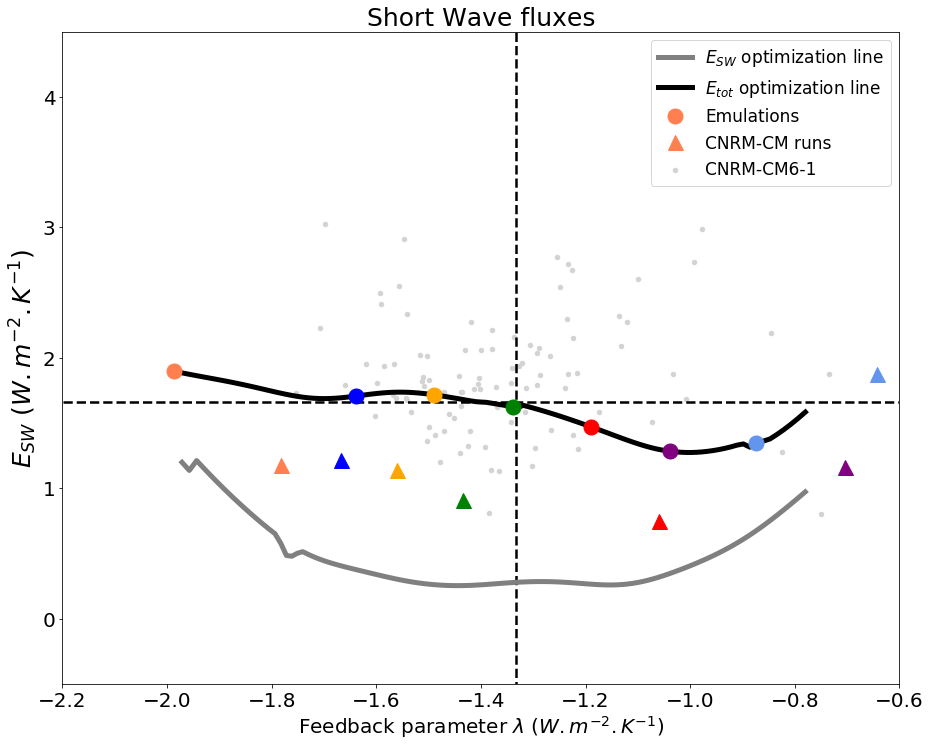

In [41]:
colors = ['coral','blue','orange','green','red','purple','cornflowerblue']
cpt=0

ax = plt.gca()

#new_df.plot(kind='scatter', x='Fdbck_pred', y='E_multilinreg_pred_best', color = 'darkgreen', alpha=0.3,
#         marker = '^', linewidth=6,  ax = ax)

#init_df.plot(kind='scatter', x='Fdbck', y='RMSE', color = 'darkgreen', alpha=1,
#         marker = '^', linewidth=6,  ax = ax)

#sol_df.plot(kind='line', x='Fdbck', y='sol_fun', color = 'darkgreen', alpha=0.3,
#         linewidth=3, ax = ax)

sol_df_2[1:].plot(kind='line', x='Fdbck', y='sol_fun', color = 'gray', alpha=1, linewidth=5, figsize=(15, 12), ax = ax)

df_optim_total_final.plot(kind='line', x='Fdbck', y='RMSE', color='black', alpha=1, linewidth=5, ax=ax)

#E_multilinreg_df.plot(kind='scatter', x='Fdbck', y='RMSE_total', 
#                           color='gray', alpha=0.2, figsize=(15, 12), marker='o', ax = ax)

PPE_df.plot(kind='scatter', x='Fdbck', y='E_PPE', color='lightgray', 
                     marker="o", ax = ax)

plt.hlines(E_p1,xmin = -10.0,xmax = 25.0,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5, zorder=1)
plt.vlines(p1_feedbacks,ymin = -10,ymax = 25,label='default simulation', colors='black', 
           linestyles='dashed', linewidth=2.5)

#plt.plot(Fdbck_MRI, E_MRI, color='orange', marker='s', markeredgewidth=0, markersize=15, zorder=20)
#plt.plot(Fdbck_CAN, E_CAN, color='navy', marker='s', markeredgewidth=2, markersize=15, zorder=30)
#plt.plot(Fdbck_MIROC, E_MIROC, color='darkred', marker='s', markeredgewidth=2, markersize=15, zorder=20)
#plt.plot(Fdbck_HadGEM3, E_HadGEM3, color='purple', marker='s', markeredgewidth=2, markersize=15, zorder=20)
#plt.plot(Fdbck_IPSL, E_IPSL, color='dodgerblue', marker='s', markeredgewidth=2, markersize=15, zorder=20)
#plt.plot(Fdbck_BCC, E_BCC, color='darkgreen', marker='s', markeredgewidth=2, markersize=15, zorder=20)


for i in colors :
    if cpt == 0 :
        plt.plot(df_select[1].iloc[cpt], E_emulator_selection[cpt], color=i, marker='o', linewidth=0, markersize=15, zorder=8)

        plt.plot(Fdbck_selection[cpt], E_df_selection[cpt], color=i, marker='^', linewidth=0, markersize=15, zorder=9)
        cpt+=1
    else :
        plt.plot(df_select[1].iloc[cpt], E_emulator_selection[cpt], color=i, marker='o', linewidth=0, markersize=15, label='_nolegend_')

        plt.plot(Fdbck_selection[cpt], E_df_selection[cpt], color=i, marker='^', linewidth=0, markersize=15, label='_nolegend_')
        cpt+=1

legend = ['$E_{SW}$ optimization line','$E_{tot}$ optimization line','Emulations','CNRM-CM runs', 
          'CNRM-CM6-1']
plt.xlabel('Feedback parameter $\lambda$ ($W.m^{-2}.K^{-1}$)', fontsize=20)
plt.ylabel(ylabel, fontsize=25)
plt.legend(legend, fontsize=17) #bbox_to_anchor=(1.05, 1)

plt.title(TITLE, fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.ylim(-0.5,4.5)
plt.xlim(-2.2,-0.6)

# Enregistrer la figure .....................

plt.savefig("/data/home/globc/peatier/figures/RMSE_"+variable+"_PPE_selection.png", 
        orientation='portrait', bbox_inches='tight', pad_inches=0.1)

# Show la figure .................
plt.show()

### Save the data

In [55]:
np.save('/data/home/globc/peatier/CNRMppe/PPE/ENSEMBLE4_selection/files/npy/E_selection_'+variable+'.npy', E_df_selection)

### [Back to the top](#top)